# Attention Gathers, MLPs Compose: A Causal Analysis of an Action-Outcome Circuit in VideoViT
			~ By Sai Chereddy

## Imports:

In [ ]:
!pip install av

In [ ]:
import torch
import numpy as np
from transformers import VivitImageProcessor, VivitForVideoClassification
from huggingface_hub import hf_hub_download
import imageio

In [ ]:
import av

In [ ]:
import matplotlib.pyplot as plt

## Bowling-strike:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- Load Model and Preprocessor ---
model_name = "google/vivit-b-16x2-kinetics400"
# The image processor handles resizing, normalization, and formatting.[2]
image_processor = VivitImageProcessor.from_pretrained(model_name)
# We load the standard Hugging Face model. We will add our own hooks to it.
model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)

print(f"'{model_name}' loaded successfully.")

'google/vivit-b-16x2-kinetics400' loaded successfully.


In [ ]:
# Enable hidden states output
model.config.output_hidden_states = True
model.eval()

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [ ]:
def load_video_from_hub(repo_id, filename):
    """Helper function to download a video and read its frames."""
    try:
        video_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset")
        # imageio.mimread reads the video into a list of numpy arrays (frames)
        return imageio.mimread(video_path, memtest=False)
    except Exception as e:
        print(f"Could not load video {filename}. Error: {e}")
        print("Please ensure you have a stable internet connection and the file exists.")
        return None

In [ ]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    np.random.seed(42)
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


In [ ]:
print("\nDownloading sample videos...")
file_path = hf_hub_download(
    repo_id="chereddysaivreddy/kinetics-400", filename="bowling/bowling_plain.mp4", repo_type="dataset"
)

In [ ]:
# --- Pre-process the Video ---
# The processor will handle everything:
# - Uniformly sample `num_frames` (32 for this model)
# - Resize each frame to the model's expected `image_size` (224x224)
# - Normalize the pixel values
container = av.open(file_path)

# sample 32 frames
indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

In [ ]:

# Dictionary to store the token representations from the final transformer layer.
activations = {}

def hook_fn(module, input, output):
    # Capture the output tokens from this transformer block.
    # (Assuming output shape: (batch, num_tokens, hidden_size))
    activations['final_tokens'] = output.detach()

# Register a hook on the output of the final transformer layer.
# Adjust the attribute path if necessary; here we assume model.vivit.encoder.layer[-1].output is valid.
hook_handle = model.vivit.encoder.layer[-1].output.register_forward_hook(hook_fn)



In [ ]:
# Preprocess the video frames to produce inputs for the model.
inputs = image_processor(list(video), return_tensors="pt")
if inputs["pixel_values"].ndim == 4:
    inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
# --- Verification ---
print(f"Shape of processed tensor: {inputs['pixel_values'].shape}")
# Expected output: torch.Size([1, 32, 3, 224, 224])
# [Batch, Num_Frames, Channels, Height, Width]

Shape of processed tensor: torch.Size([1, 32, 3, 224, 224])


In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    hidden_states = outputs.hidden_states

# model predicts one of the 400 Kinetics-400 classes
# Here, we take the model's predicted class.
target_class = torch.argmax(logits, dim=-1).item()
print(model.config.id2label[target_class])

LABEL_31


### DLA:

In [ ]:
# Get the classifier's weight vector for the target class.
classifier_weights = model.classifier.weight  # shape: (num_classes, hidden_size)
target_weight = classifier_weights[target_class]  # shape: (hidden_size)

# Retrieve the token representations from the hook.
# Expected shape: (1, num_tokens, hidden_size)
tokens = activations['final_tokens'].squeeze(0)  # shape: (num_tokens, hidden_size)

cls_token = tokens[0]  # using only the CLS token

cls_token_norm = model.vivit.layernorm(cls_token)

# Get the classifier's weight and bias.
classifier_weights = model.classifier.weight  # shape: (num_classes, hidden_size)
classifier_bias = model.classifier.bias         # shape: (num_classes,)

target_class = torch.argmax(logits, dim=-1).item()
target_weight = classifier_weights[target_class]  # shape: (hidden_size,)
target_bias = classifier_bias[target_class]         # scalar


cls_contribution = torch.dot(cls_token_norm, target_weight) + target_bias


print("Direct logit attribution (CLS token with normalization):", cls_contribution.item())
print("Model logit for target class:", logits[0, target_class].item())

Direct logit attribution (CLS token with normalization): 16.99542808532715
Model logit for target class: 16.99542808532715


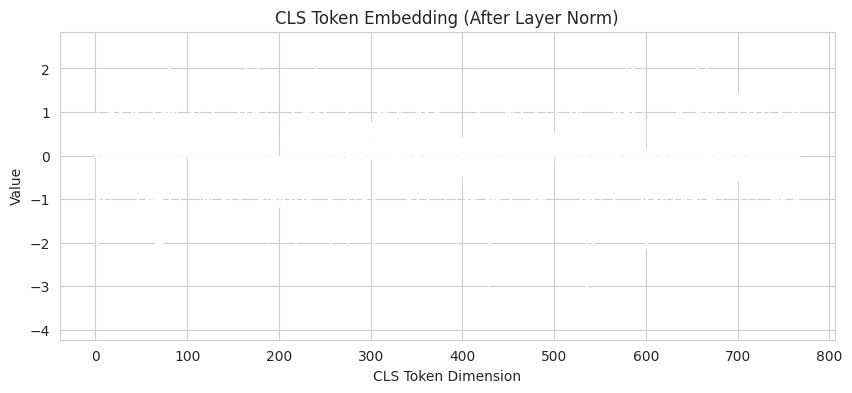

In [ ]:
# For visualization, assume each token corresponds to a frame.
num_tokens = tokens.shape[0]
cls_np = cls_token_norm.detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.bar(range(len(cls_np)), cls_np)
plt.xlabel("CLS Token Dimension")
plt.ylabel("Value")
plt.title("CLS Token Embedding (After Layer Norm)")
plt.show()

# Remove the hook when done.
hook_handle.remove()

In [ ]:
# --- Direct Logit Attribution at Token Level ---
# We already have the final tokens via the hook
tokens = activations['final_tokens'].squeeze(0)  # shape: (num_tokens, hidden_size)
print("Total tokens (including CLS):", tokens.shape[0])

# The model uses a CLS token at index 0.
cls_token = tokens[0]  # used for overall logit
tokens_without_cls = tokens[1:]  # these are the per-patch tokens

# Get classifier weights for the predicted class
classifier_weights = model.classifier.weight  # shape: (num_classes, hidden_size)
classifier_bias = model.classifier.bias         # shape: (num_classes,)
target_weight = classifier_weights[target_class]  # shape: (hidden_size,)
target_bias = classifier_bias[target_class]         # scalar

# Compute dot product for each token
token_contributions = torch.matmul(tokens_without_cls, target_weight)  # shape: (num_tokens-1,)

# To see which token contributes most, you can sort or visualize them
print("Max token contribution:", token_contributions.max().item())
print("Min token contribution:", token_contributions.min().item())

Total tokens (including CLS): 3137
Max token contribution: 145.11831665039062
Min token contribution: 5.845818519592285


Tokens per frame: 98


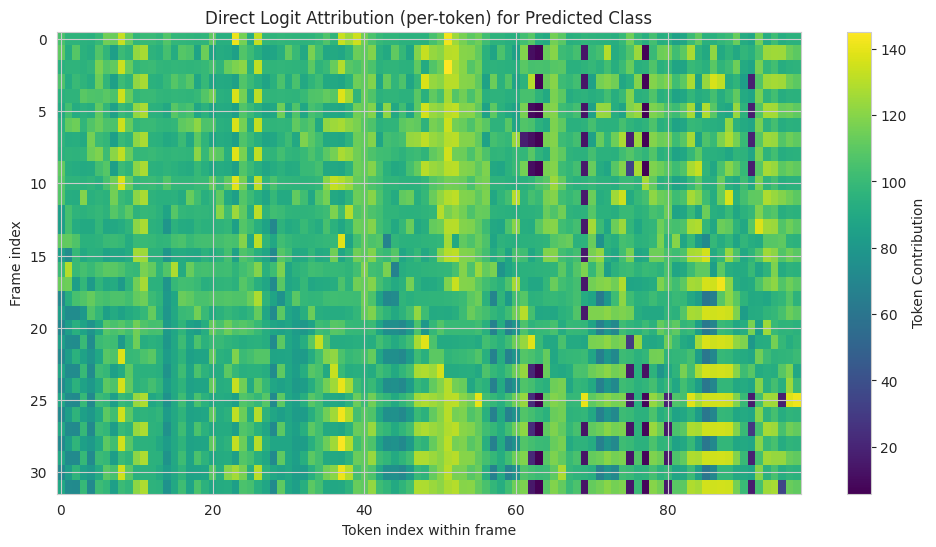

In [ ]:
# --- Reshape token contributions to map to frames ---

# Determine tokens per frame:
total_tokens_without_cls = tokens_without_cls.shape[0]
num_frames = 32  # since we sampled 32 frames
tokens_per_frame = total_tokens_without_cls // num_frames
print("Tokens per frame:", tokens_per_frame)

# Reshape contributions: shape (num_frames, tokens_per_frame)
token_contributions_reshaped = token_contributions.detach().cpu().numpy().reshape(num_frames, tokens_per_frame)


# Plot per-frame logit contributions
# Plot heatmap of token contributions per frame
plt.figure(figsize=(12, 6))
plt.imshow(token_contributions_reshaped, cmap="viridis", aspect="auto")
plt.colorbar(label="Token Contribution")
plt.xlabel("Token index within frame")
plt.ylabel("Frame index")
plt.title("Direct Logit Attribution (per-token) for Predicted Class")
plt.show()

In [ ]:
def compute_layerwise_logits(model, inputs):
    """
    Computes the layerwise target class logit for a single video input.
    Returns a list of logits for each layer (from 0 to 12) and the target class index.
    """

    layer_logits = []
    for layer_idx, hs in enumerate(hidden_states):
        # hs shape: (1, total_tokens, hidden_size); we extract the CLS token (index 0)
        cls_token = hs[0, 0]  # shape: (hidden_size,)
        # Apply the same layer norm that the model uses before classification
        cls_token_norm = model.vivit.layernorm(cls_token)
        # Compute the logit for target class: dot product plus bias
        logit = torch.dot(cls_token_norm, target_weight) + target_bias
        layer_logits.append(logit.item())
    return layer_logits, target_class

# Number of video samples to simulate variability (ideally these would be different videos)
num_samples = 10
all_layer_logits = []  # Will be a list of lists; each inner list has logits from layers 0 to 12

for i in range(num_samples):
    layer_logits, target_class = compute_layerwise_logits(model, inputs)
    all_layer_logits.append(layer_logits)

all_layer_logits = np.array(all_layer_logits)  # Shape: (num_samples, num_layers+1)
num_layers = all_layer_logits.shape[1]


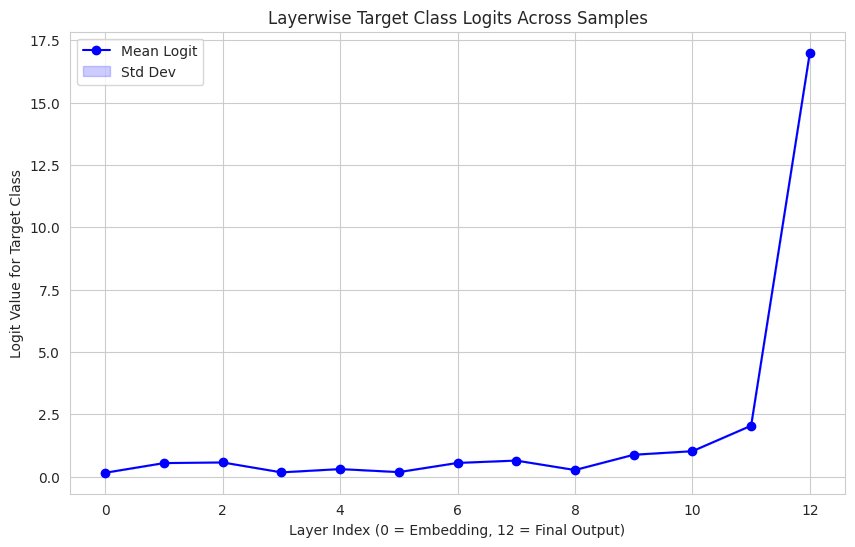

In [ ]:
# Compute the mean and standard deviation for each layer across samples.
mean_logits = np.mean(all_layer_logits, axis=0)
std_logits = np.std(all_layer_logits, axis=0)
layers = np.arange(mean_logits.shape[0])  # layer indices 0 to 12

plt.figure(figsize=(10, 6))
plt.plot(layers, mean_logits, marker='o', linestyle='-', color='blue', label="Mean Logit")
plt.fill_between(layers, mean_logits - std_logits, mean_logits + std_logits,
                 color='blue', alpha=0.2, label="Std Dev")
plt.xlabel("Layer Index (0 = Embedding, 12 = Final Output)")
plt.ylabel("Logit Value for Target Class")
plt.title("Layerwise Target Class Logits Across Samples")
plt.legend()
plt.show()

In [ ]:
# --- Direct Logit Attribution at Token Level ---

tokens = activations['final_tokens'].squeeze(0)  # (3137, hidden_dim)
print("Total tokens (incl CLS):", tokens.shape[0])

# Drop CLS
tokens_no_cls = tokens[1:]  # (3136, hidden_dim)

# Model params
num_frames = 32
tubelet = 2
h = w = 14  # 224/16 = 14
time = num_frames // tubelet  # 16 tubelets

# Reshape tokens into (time, h, w, hidden_dim)
tokens_reshaped = tokens_no_cls.view(time, h, w, -1)

# Classifier weights
target_class = outputs.logits.argmax(-1).item()
class_w = model.classifier.weight[target_class].to(device)

# Compute contribution per tubelet token
contribs = torch.einsum("thwd,d->thw", tokens_reshaped, class_w)

# Expand tubelets back to 32 frames (duplicate each 2-frame tubelet)
frame_contribs = contribs.repeat_interleave(tubelet, axis=0)  # (32, 14, 14)

print("Frame contribs shape:", frame_contribs.shape)  # (32, 14, 14)


Total tokens (incl CLS): 3137
Frame contribs shape: torch.Size([32, 14, 14])


### CLS Token Visualisation:

In [ ]:
# --- Load Model and Preprocessor ---
model_name = "google/vivit-b-16x2-kinetics400"
# The image processor handles resizing, normalization, and formatting.[2]
image_processor = VivitImageProcessor.from_pretrained(model_name)
# We load the standard Hugging Face model. We will add our own hooks to it.
model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)

print(f"'{model_name}' loaded successfully.")

'google/vivit-b-16x2-kinetics400' loaded successfully.


In [ ]:
# Enable hidden states output (returns a tuple of 13 hidden states for a 12-layer model)
model.config.output_hidden_states = True
model.eval()

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# This dictionary will store the attention weights from each layer
attention_cache = {}

def get_attention_hook(name):
    """Creates a hook to save attention probabilities."""
    def hook(model, input, output):
        # The attention module's output is a tuple: (hidden_states, attention_probs)
        # We want the second element, the probabilities.
        attention_cache[name] = output[1].detach()
    return hook

# --- Register hooks on ALL attention layers ---
# In ViViT, this is inside model.vivit.encoder.layer[i].attention.attention
for i, layer in enumerate(model.vivit.encoder.layer):
    layer.attention.attention.register_forward_hook(get_attention_hook(f"layer_{i}"))

# --- Run inference to trigger the hooks ---
with torch.no_grad():
    outputs = model(inputs["pixel_values"], output_attentions=True)

# Now, attention_cache is populated with keys 'layer_0', 'layer_1', ..., 'layer_11'
print(f"Captured attention from {len(attention_cache)} layers.")

Captured attention from 12 layers.


Derived 98 patches per frame.


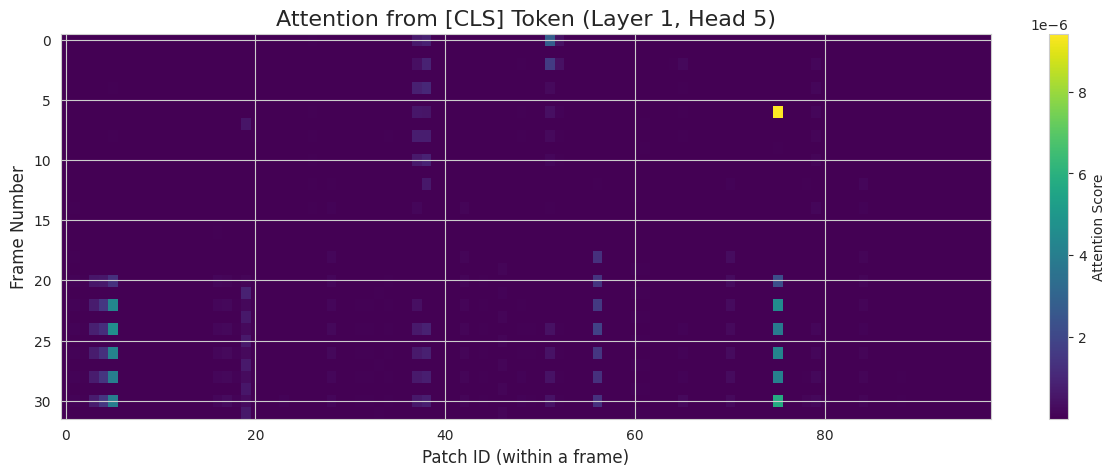

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 1
HEAD_ID = 5
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
# Instead of relying on config, we calculate patches directly from the tensor shape.
num_frames = model.config.num_frames  # 32
# The total number of patches is simply the length of our cls_attention tensor.
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

# This is the most robust way to calculate it.
print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

Derived 98 patches per frame.


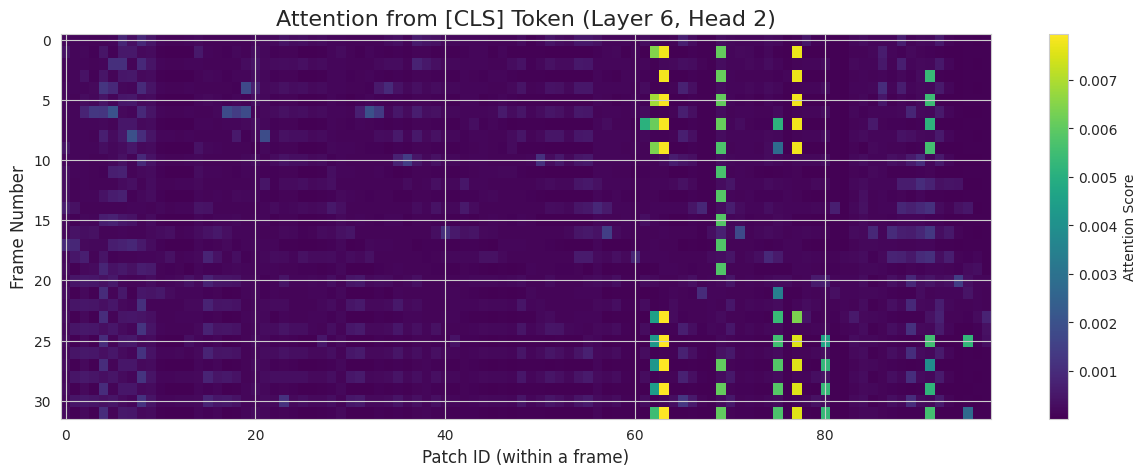

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 6
HEAD_ID = 2
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
# Instead of relying on config, we calculate patches directly from the tensor shape.
num_frames = model.config.num_frames  # 32
# The total number of patches is simply the length of our cls_attention tensor.
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

# This is the most robust way to calculate it.
print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 9
HEAD_ID = 8
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
# Instead of relying on config, we calculate patches directly from the tensor shape.
num_frames = model.config.num_frames  # 32
# The total number of patches is simply the length of our cls_attention tensor.
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

# This is the most robust way to calculate it.
print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

Derived 98 patches per frame.


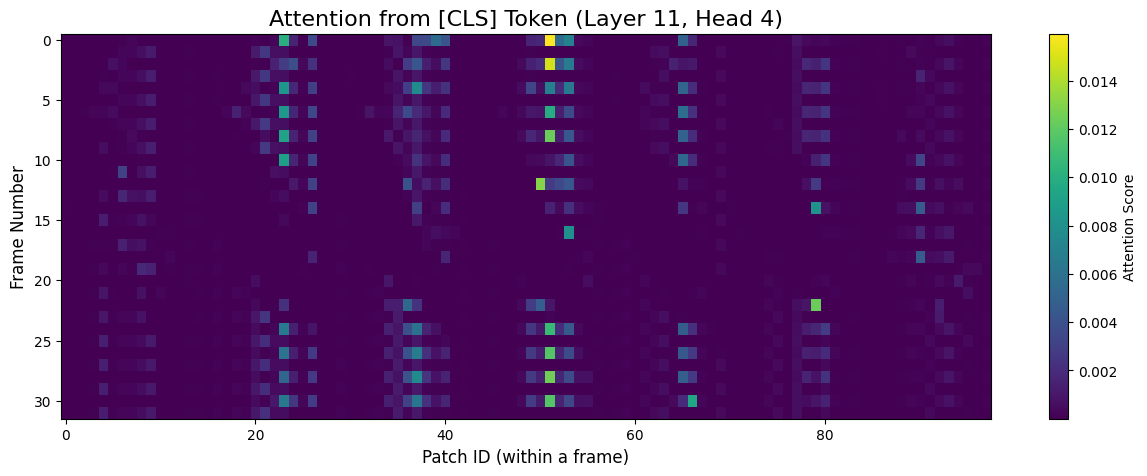

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 11  # Let's inspect the final layer
HEAD_ID = 4   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
# Instead of relying on config, we calculate patches directly from the tensor shape.
num_frames = model.config.num_frames  # 32
# The total number of patches is simply the length of our cls_attention tensor.
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

# This is the most robust way to calculate it.
print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

In [ ]:
def plot_attention_heatmaps(layer_id, head_ids, num_frames=32):
    """
    Plots attention heatmaps for a given layer and a list of heads.

    Args:
        layer_id (int): The layer index to visualize (0-11).
        head_ids (list): A list of head indices to visualize (0-11).
        num_frames (int): The number of frames in the video.
    """

    num_heads_to_plot = len(head_ids)

    fig, axes = plt.subplots(1, num_heads_to_plot, figsize=(5 * num_heads_to_plot, 5))

    # Ensure axes is an array even for a single head
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i, head_id in enumerate(head_ids):
        # The [CLS] token is the first token (index 0).
        attention_for_head = attention_cache[f"layer_{layer_id}"][0, head_id, :, :]
        cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

        # Calculate patches per frame from the tensor shape
        num_patches = cls_attention.shape[0]
        num_patches_per_frame = num_patches // num_frames

        # Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
        heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

        im = axes[i].imshow(heatmap, cmap='viridis', aspect='auto')
        axes[i].set_title(f'Layer {layer_id}, Head {head_id}', fontsize=12)
        axes[i].set_xlabel('Patch ID (within a frame)', fontsize=10)
        if i == 0:
            # Only set y-label for the first plot for a cleaner look
            axes[i].set_ylabel('Frame Number', fontsize=10)

    fig.suptitle(f'Attention from [CLS] Token (Layer {layer_id})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

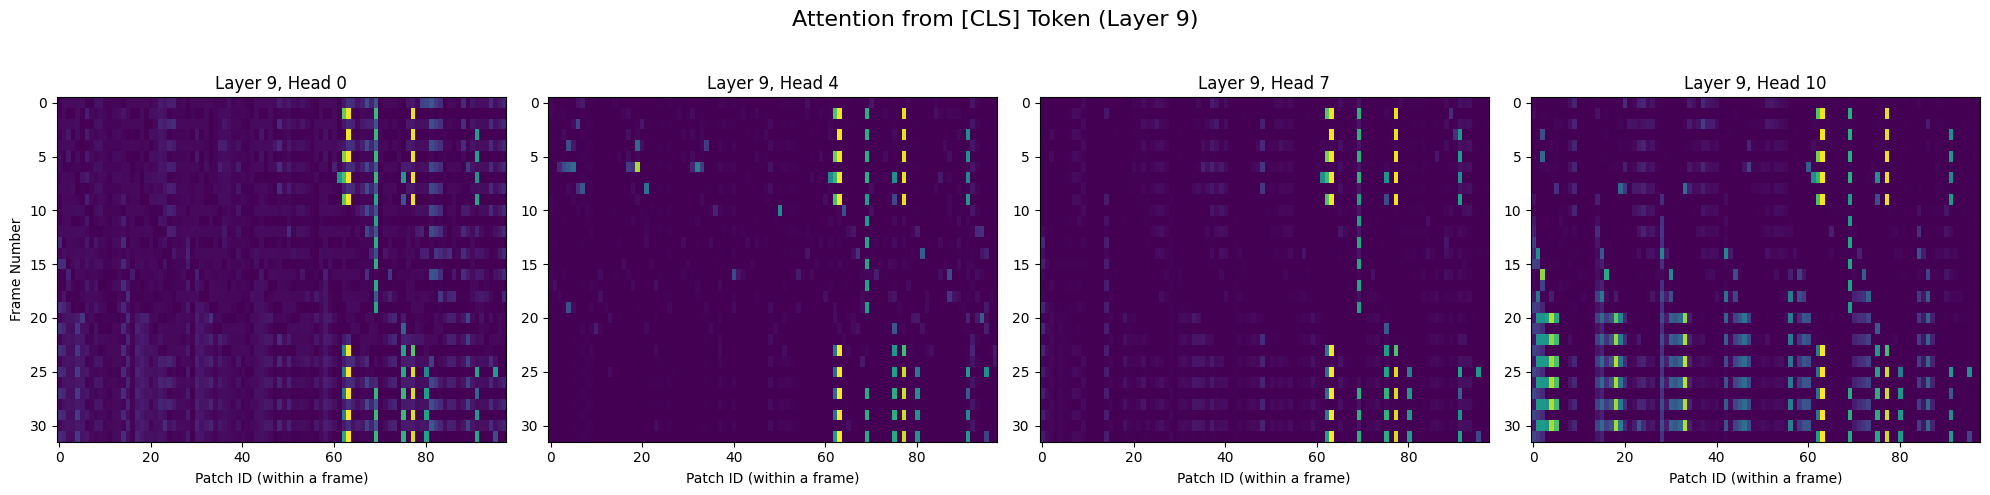

In [ ]:
plot_attention_heatmaps(layer_id=9, head_ids=[0, 4, 7, 10])

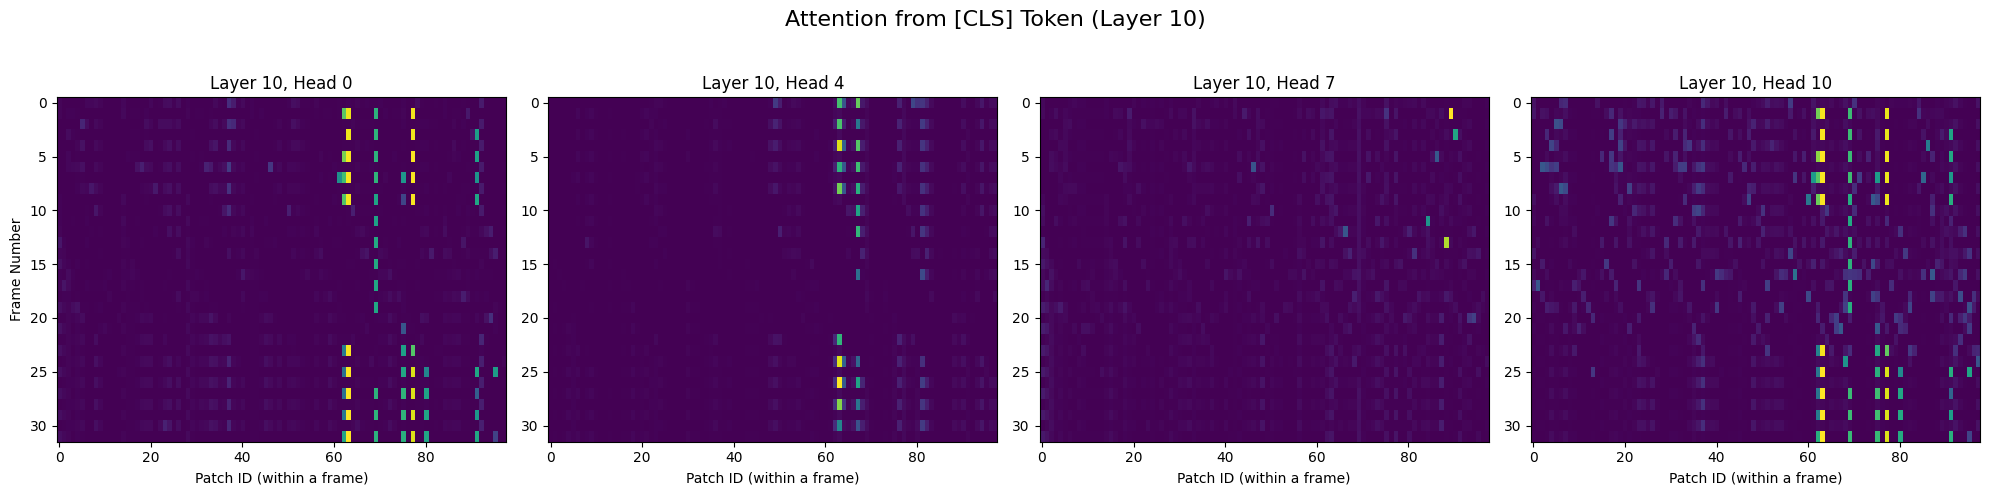

In [ ]:
plot_attention_heatmaps(layer_id=10, head_ids=[0, 4, 7, 10])

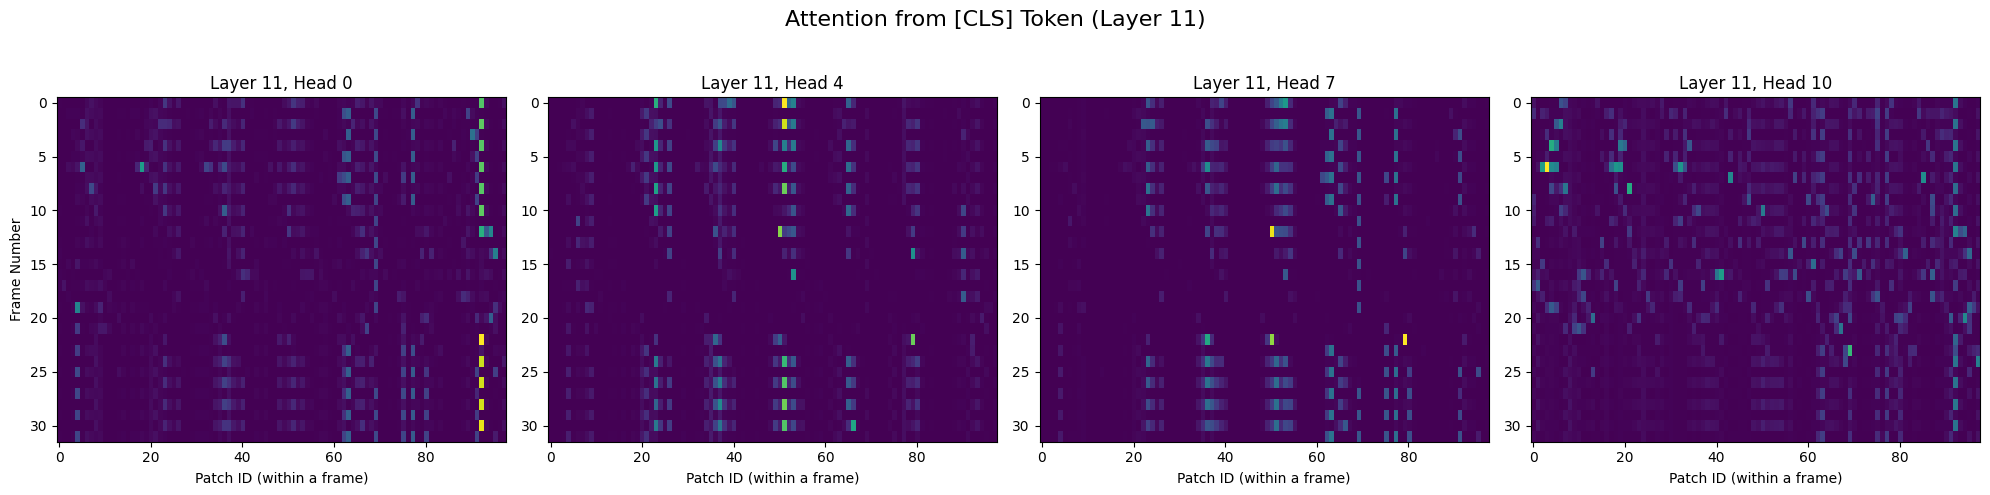

In [ ]:
plot_attention_heatmaps(layer_id=11, head_ids=[0, 4, 7, 10])

In [ ]:
# --- Clean up hooks ---
hook_handle.remove()

### Ablation:

In [ ]:
CRITICAL_LAYER = 9
CRITICAL_HEAD = 0
CRITICAL_FRAME = 5
CRITICAL_PATCH_ID = 76

# ---Perform the targeted ablation ---
# The attention_for_head tensor has a shape of (num_tokens, num_tokens).
# We want to ablate the attention from the [CLS] token (index 0) to the
# critical patch token. The patch tokens start at index 1.
# The index of the critical patch token in the sequence is:
# (CRITICAL_FRAME * num_patches_per_frame) + CRITICAL_PATCH_ID + 1
# Let's assume num_patches_per_frame is 196 (14x14 grid).
num_patches_per_frame = 196
critical_token_index = (CRITICAL_FRAME * num_patches_per_frame) + CRITICAL_PATCH_ID + 1

# Create a copy of the original pixel values to ablate
ablated_pixel_values = inputs['pixel_values'].clone()

# To ablate the patch, we'll set its pixel values to zero.
# The pixel values are organized as: (batch, num_frames, channels, height, width).
# The patch size is 16x16.
patch_size = 16
patch_h_start = (CRITICAL_PATCH_ID // 14) * patch_size
patch_w_start = (CRITICAL_PATCH_ID % 14) * patch_size

ablated_pixel_values[:,
                     CRITICAL_FRAME,
                     :,
                     patch_h_start:patch_h_start + patch_size,
                     patch_w_start:patch_w_start + patch_size] = 0

# ---Run the ablated video through the model and compare logits ---
with torch.no_grad():
    ablated_outputs = model(ablated_pixel_values)
    ablated_logits = ablated_outputs.logits

    original_logit_score = outputs.logits[0, target_class].item()
    ablated_logit_score = ablated_logits[0, target_class].item()

print(f"Original Logit for '{model.config.id2label[target_class]}': {original_logit_score:.4f}")
print(f"Ablated Logit for '{model.config.id2label[target_class]}': {ablated_logit_score:.4f}")

logit_change = original_logit_score - ablated_logit_score
print(f"Logit Drop: {logit_change:.4f}")

Original Logit for 'LABEL_31': 16.9954
Ablated Logit for 'LABEL_31': 16.9901
Logit Drop: 0.0053


In [ ]:
CRITICAL_LAYER = 11
CRITICAL_HEAD = 7
CRITICAL_FRAME = 23
CRITICAL_PATCH_ID = 68

num_patches_per_frame = 196
critical_token_index = (CRITICAL_FRAME * num_patches_per_frame) + CRITICAL_PATCH_ID + 1

# Create a copy of the original pixel values to ablate
ablated_pixel_values = inputs['pixel_values'].clone()

# To ablate the patch, we'll set its pixel values to zero.
# The pixel values are organized as: (batch, num_frames, channels, height, width).
# The patch size is 16x16.
patch_size = 16
patch_h_start = (CRITICAL_PATCH_ID // 14) * patch_size
patch_w_start = (CRITICAL_PATCH_ID % 14) * patch_size

ablated_pixel_values[:,
                     CRITICAL_FRAME,
                     :,
                     patch_h_start:patch_h_start + patch_size,
                     patch_w_start:patch_w_start + patch_size] = 0

# ---Run the ablated video through the model and compare logits ---
with torch.no_grad():
    ablated_outputs = model(ablated_pixel_values)
    ablated_logits = ablated_outputs.logits

    original_logit_score = outputs.logits[0, target_class].item()
    ablated_logit_score = ablated_logits[0, target_class].item()

print(f"Original Logit for '{model.config.id2label[target_class]}': {original_logit_score:.4f}")
print(f"Ablated Logit for '{model.config.id2label[target_class]}': {ablated_logit_score:.4f}")

logit_change = original_logit_score - ablated_logit_score
print(f"Logit Drop: {logit_change:.4f}")

Original Logit for 'LABEL_31': 16.9954
Ablated Logit for 'LABEL_31': 16.9914
Logit Drop: 0.0040


In [ ]:
import torch

# ---Define the Critical Frames to Ablate ---
# Based on findings that frames 11-12 are the hotspot
FRAME_START = 10
FRAME_END = 13 # Ablating frames 10, 11, 12, 13

# ---Create the Ablated Input Tensor ---
# Start with a copy of the original, correctly processed pixel_values
ablated_pixel_values = inputs['pixel_values'].clone()

# Zero out the pixel values for the critical frames
# The shape is (1, 32, 3, 224, 224) -> (Batch, Frames, Channels, H, W)
ablated_pixel_values[:, FRAME_START:FRAME_END+1, :, :, :] = 0

print(f"Ablated (zeroed out) frames {FRAME_START} through {FRAME_END}.")

# --- Measure the Impact of Ablation ---

# Get the original logits and predicted class
with torch.no_grad():
    original_outputs = model(inputs["pixel_values"], output_attentions=True)
    original_logits = original_outputs.logits
    # The predicted class index for the original video
    predicted_class_idx = original_logits.argmax(-1).item()
    original_logit_score = original_logits[0, predicted_class_idx]
    original_class_name = model.config.id2label[predicted_class_idx]

# Get the logits using the ablated input
with torch.no_grad():
    ablated_outputs = model(ablated_pixel_values, output_attentions=True)
    ablated_logits = ablated_outputs.logits
    # Get the logit score FOR THE ORIGINAL CLASS
    ablated_logit_score_for_original_class = ablated_logits[0, predicted_class_idx]

    # Also, let's see what the model predicts now
    new_predicted_class_idx = ablated_logits.argmax(-1).item()
    new_class_name = model.config.id2label[new_predicted_class_idx]


# --- 4. Report the Results ---
print(f"\nOriginal Predicted Class: '{original_class_name}' (Logit: {original_logit_score:.4f})")
print(f"Ablated Logit for '{original_class_name}': {ablated_logit_score_for_original_class:.4f}")

logit_change = original_logit_score - ablated_logit_score_for_original_class
print(f"Logit Drop: {logit_change:.4f}")

print(f"\nNew Predicted Class after Ablation: '{new_class_name}'")

Ablated (zeroed out) frames 10 through 13.

Original Predicted Class: 'LABEL_31' (Logit: 16.9954)
Ablated Logit for 'LABEL_31': 17.0793
Logit Drop: -0.0839

New Predicted Class after Ablation: 'LABEL_31'


In [ ]:
import torch
import torch.nn.functional as F
import gc

# Reload the model to ensure all old hooks are gone.
print("Reloading a fresh model to guarantee no lingering hooks...")
model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400").to(device)
print("Model reloaded successfully.")


# --- Run the Lean Logit Analysis ---

# --- Process ORIGINAL video ---
with torch.no_grad():
    original_outputs = model(inputs["pixel_values"])
    original_logits = original_outputs.logits[0]

original_top5 = torch.topk(F.softmax(original_logits, dim=-1), 5)
original_top5_indices_cpu = original_top5.indices.cpu()
original_logits_cpu = original_logits.cpu()

# Clean up memory
del original_outputs, original_logits
torch.cuda.empty_cache()
gc.collect()

# --- Process ABLATED video ---
with torch.no_grad():
    ablated_outputs = model(ablated_pixel_values)
    ablated_logits = ablated_outputs.logits[0]

ablated_top5 = torch.topk(F.softmax(ablated_logits, dim=-1), 5)
ablated_top5_indices_cpu = ablated_top5.indices.cpu()
ablated_logits_cpu = ablated_logits.cpu()

# Clean up memory
del ablated_outputs, ablated_logits
torch.cuda.empty_cache()
gc.collect()


# --- Compare the results ---
print("\n--- ORIGINAL PREDICTIONS ---")
for i in range(5):
    class_idx = original_top5_indices_cpu[i].item()
    class_name = model.config.id2label[class_idx]
    logit_val = original_logits_cpu[class_idx].item()
    print(f"{i+1}. {class_name:<25} (Logit: {logit_val:.4f})")

print("\n--- ABLATED PREDICTIONS ---")
for i in range(5):
    class_idx = ablated_top5_indices_cpu[i].item()
    class_name = model.config.id2label[class_idx]
    logit_val = ablated_logits_cpu[class_idx].item()
    print(f"{i+1}. {class_name:<25} (Logit: {logit_val:.4f})")

print("\n--- ANALYSIS OF KEY LOGIT CHANGES ---")
for i in range(5):
    class_idx = original_top5_indices_cpu[i].item()
    class_name = model.config.id2label[class_idx]

    original_logit = original_logits_cpu[class_idx].item()
    ablated_logit = ablated_logits_cpu[class_idx].item()
    change = ablated_logit - original_logit

    print(f"Change for '{class_name}': {change:.4f}")

Reloading a fresh model to guarantee no lingering hooks...
Model reloaded successfully.

--- ORIGINAL PREDICTIONS ---
1. LABEL_31                  (Logit: 16.9954)
2. LABEL_357                 (Logit: 9.0371)
3. LABEL_227                 (Logit: 6.2185)
4. LABEL_152                 (Logit: 5.9146)
5. LABEL_84                  (Logit: 5.7508)

--- ABLATED PREDICTIONS ---
1. LABEL_31                  (Logit: 17.0793)
2. LABEL_357                 (Logit: 8.9642)
3. LABEL_227                 (Logit: 6.3996)
4. LABEL_152                 (Logit: 6.0933)
5. LABEL_84                  (Logit: 5.7547)

--- ANALYSIS OF KEY LOGIT CHANGES ---
Change for 'LABEL_31': 0.0839
Change for 'LABEL_357': -0.0729
Change for 'LABEL_227': 0.1811
Change for 'LABEL_152': 0.1786
Change for 'LABEL_84': 0.0040


## Bowling-gutter

In [ ]:
import torch
import numpy as np
from transformers import VivitImageProcessor, VivitForVideoClassification
from huggingface_hub import hf_hub_download
import imageio

In [ ]:
import av

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- Load Model and Preprocessor ---
model_name = "google/vivit-b-16x2-kinetics400"

image_processor = VivitImageProcessor.from_pretrained(model_name)

model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)

print(f"'{model_name}' loaded successfully.")

'google/vivit-b-16x2-kinetics400' loaded successfully.


In [ ]:
# Enable hidden states output (returns a tuple of 13 hidden states for a 12-layer model)
model.config.output_hidden_states = True
model.eval()

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [ ]:
def load_video_from_hub(repo_id, filename):
    """Helper function to download a video and read its frames."""
    try:
        video_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset")
        return imageio.mimread(video_path, memtest=False)
    except Exception as e:
        print(f"Could not load video {filename}. Error: {e}")
        print("Please ensure you have a stable internet connection and the file exists.")
        return None

In [ ]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


In [ ]:
print("\nDownloading sample videos...")
file_path = hf_hub_download(
    repo_id="chereddysaivreddy/kinetics-400", filename="bowling/bowling_gutter.mp4", repo_type="dataset"
)

bowling/bowling_gutter.mp4:   0%|          | 0.00/441k [00:00<?, ?B/s]

In [ ]:
# --- Pre-process the Video ---
# The processor will handle everything:
# - Uniformly sample `num_frames` (32 for this model)
# - Resize each frame to the model's expected `image_size` (224x224)
# - Normalize the pixel values
container = av.open(file_path)

# sample 32 frames
indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

In [ ]:
# Dictionary to store the token representations from the final transformer layer.
activations = {}

def hook_fn(module, input, output):
    # Capture the output tokens from this transformer block.
    # (Assuming output shape: (batch, num_tokens, hidden_size))
    activations['final_tokens'] = output.detach()

# Register a hook on the output of the final transformer layer.
# Adjust the attribute path if necessary; here we assume model.vivit.encoder.layer[-1].output is valid.
hook_handle = model.vivit.encoder.layer[-1].output.register_forward_hook(hook_fn)


In [ ]:
# Preprocess the video frames to produce inputs for the model.
inputs = image_processor(list(video), return_tensors="pt")
if inputs["pixel_values"].ndim == 4:
    inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
# --- 4. Verification ---
print(f"Shape of processed tensor: {inputs["pixel_values"].shape}")
# Expected output: torch.Size([1, 32, 3, 224, 224])
# [Batch, Num_Frames, Channels, Height, Width]

Shape of processed tensor: torch.Size([1, 32, 3, 224, 224])


In [ ]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits
    hidden_states = outputs.hidden_states

# model predicts one of the 400 Kinetics-400 classes
# Here, we take the model's predicted class.
target_class = torch.argmax(logits, dim=-1).item()
print(model.config.id2label[target_class])

LABEL_31


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# This dictionary will store the attention weights from each layer
attention_cache = {}

def get_attention_hook(name):
    """Creates a hook to save attention probabilities."""
    def hook(model, input, output):
        # The attention module's output is a tuple: (hidden_states, attention_probs)
        # We want the second element, the probabilities.
        attention_cache[name] = output[1].detach()
    return hook

# --- Register hooks on ALL attention layers ---
# In ViViT, this is inside model.vivit.encoder.layer[i].attention.attention
for i, layer in enumerate(model.vivit.encoder.layer):
    layer.attention.attention.register_forward_hook(get_attention_hook(f"layer_{i}"))

# --- Run inference to trigger the hooks ---
with torch.no_grad():
    outputs = model(inputs["pixel_values"], output_attentions=True)

# Now, attention_cache is populated with keys 'layer_0', 'layer_1', ..., 'layer_11'
print(f"Captured attention from {len(attention_cache)} layers.")

Captured attention from 12 layers.


Derived 98 patches per frame.


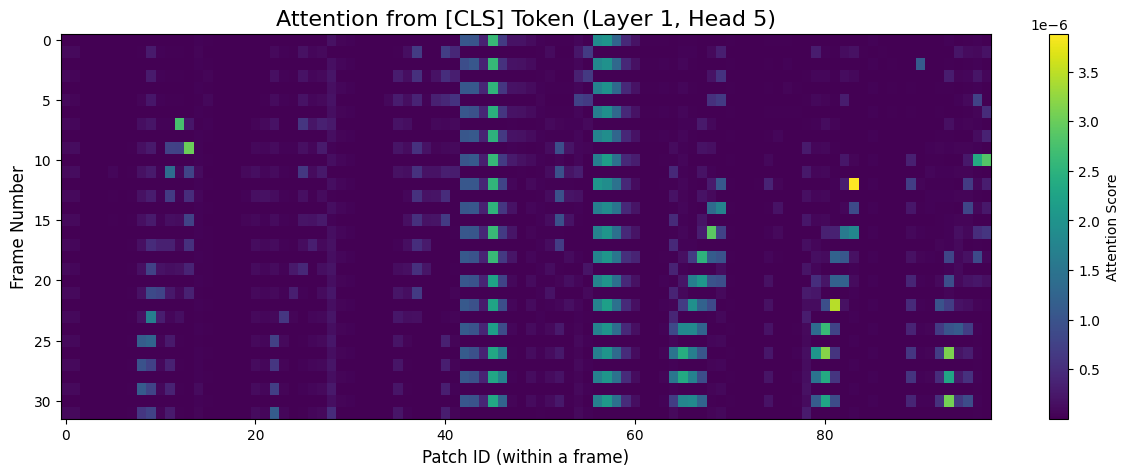

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 1  # Let's inspect the final layer
HEAD_ID = 5   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
num_frames = model.config.num_frames  # 32
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

Derived 98 patches per frame.


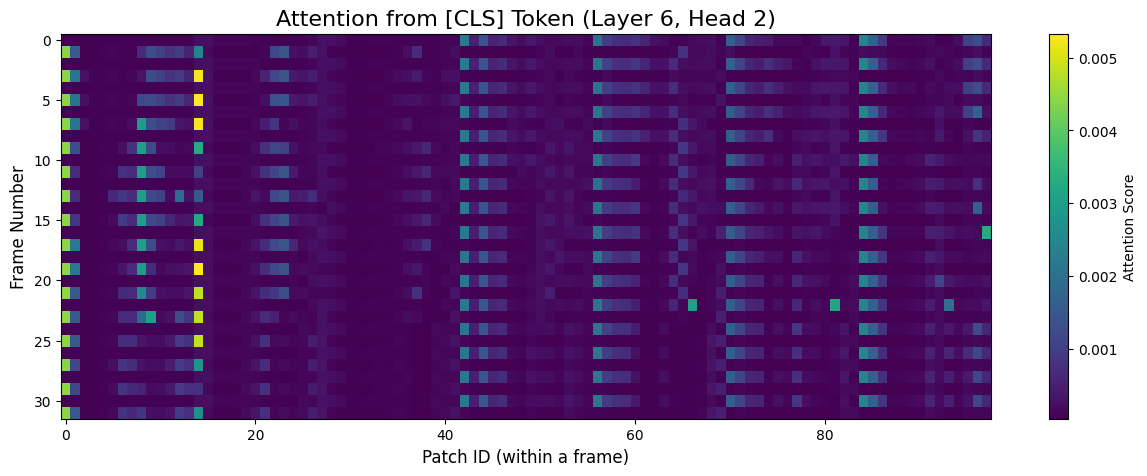

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 6  # Let's inspect the final layer
HEAD_ID = 2   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
num_frames = model.config.num_frames  # 32
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

Derived 98 patches per frame.


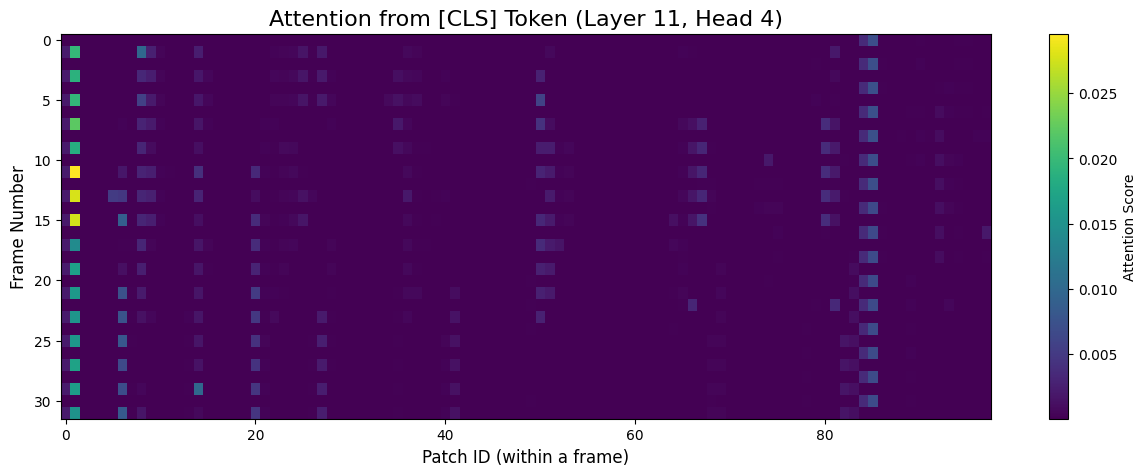

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 11  # Let's inspect the final layer
HEAD_ID = 4   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
num_frames = model.config.num_frames  # 32
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

In [ ]:
def plot_attention_heatmaps(layer_id, head_ids, num_frames=32):
    """
    Plots attention heatmaps for a given layer and a list of heads.

    Args:
        layer_id (int): The layer index to visualize (0-11).
        head_ids (list): A list of head indices to visualize (0-11).
        num_frames (int): The number of frames in the video.
    """

    num_heads_to_plot = len(head_ids)

    # We create a subplot for each head to compare them easily.
    fig, axes = plt.subplots(1, num_heads_to_plot, figsize=(5 * num_heads_to_plot, 5))

    # Ensure axes is an array even for a single head
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i, head_id in enumerate(head_ids):
        # The [CLS] token is the first token (index 0).
        attention_for_head = attention_cache[f"layer_{layer_id}"][0, head_id, :, :]
        cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

        # Calculate patches per frame from the tensor shape
        num_patches = cls_attention.shape[0]
        num_patches_per_frame = num_patches // num_frames

        # Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
        heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

        im = axes[i].imshow(heatmap, cmap='viridis', aspect='auto')
        axes[i].set_title(f'Layer {layer_id}, Head {head_id}', fontsize=12)
        axes[i].set_xlabel('Patch ID (within a frame)', fontsize=10)
        if i == 0:
            # Only set y-label for the first plot for a cleaner look
            axes[i].set_ylabel('Frame Number', fontsize=10)

    fig.suptitle(f'Attention from [CLS] Token (Layer {layer_id})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

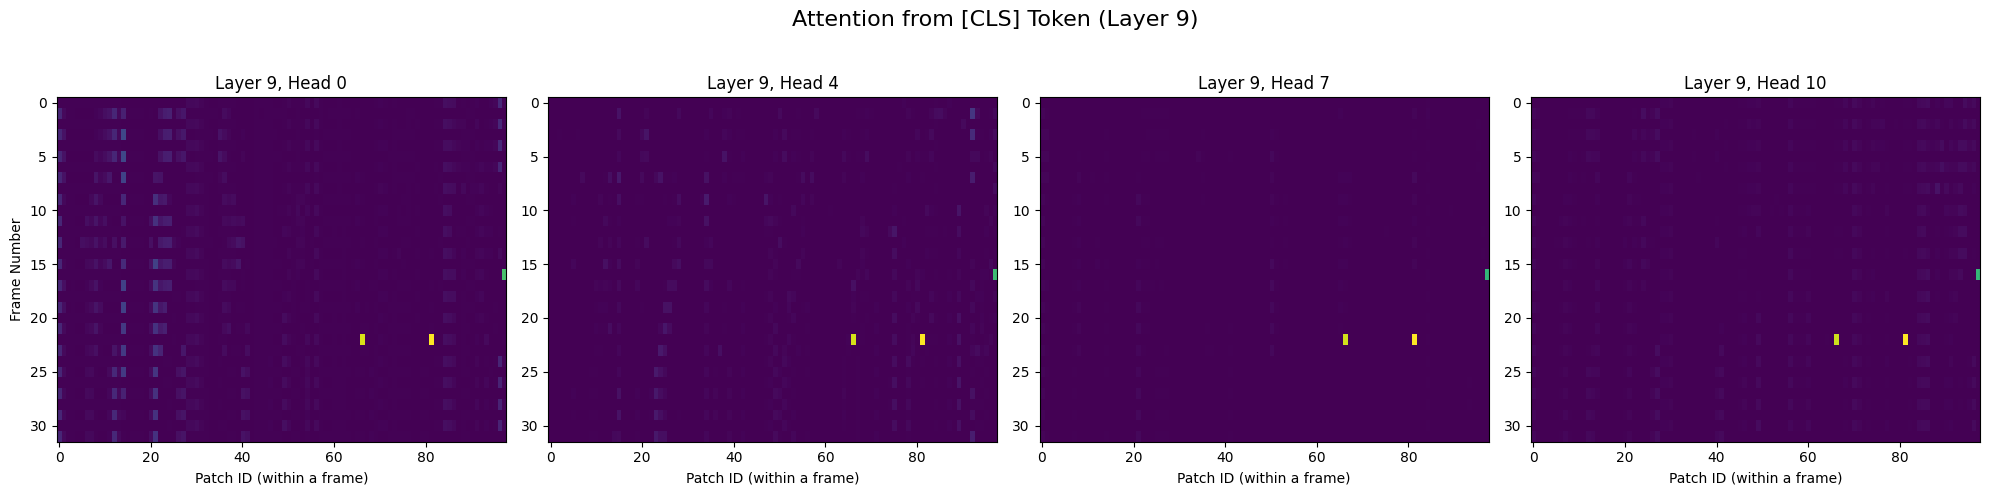

In [ ]:
plot_attention_heatmaps(layer_id=9, head_ids=[0, 4, 7, 10])



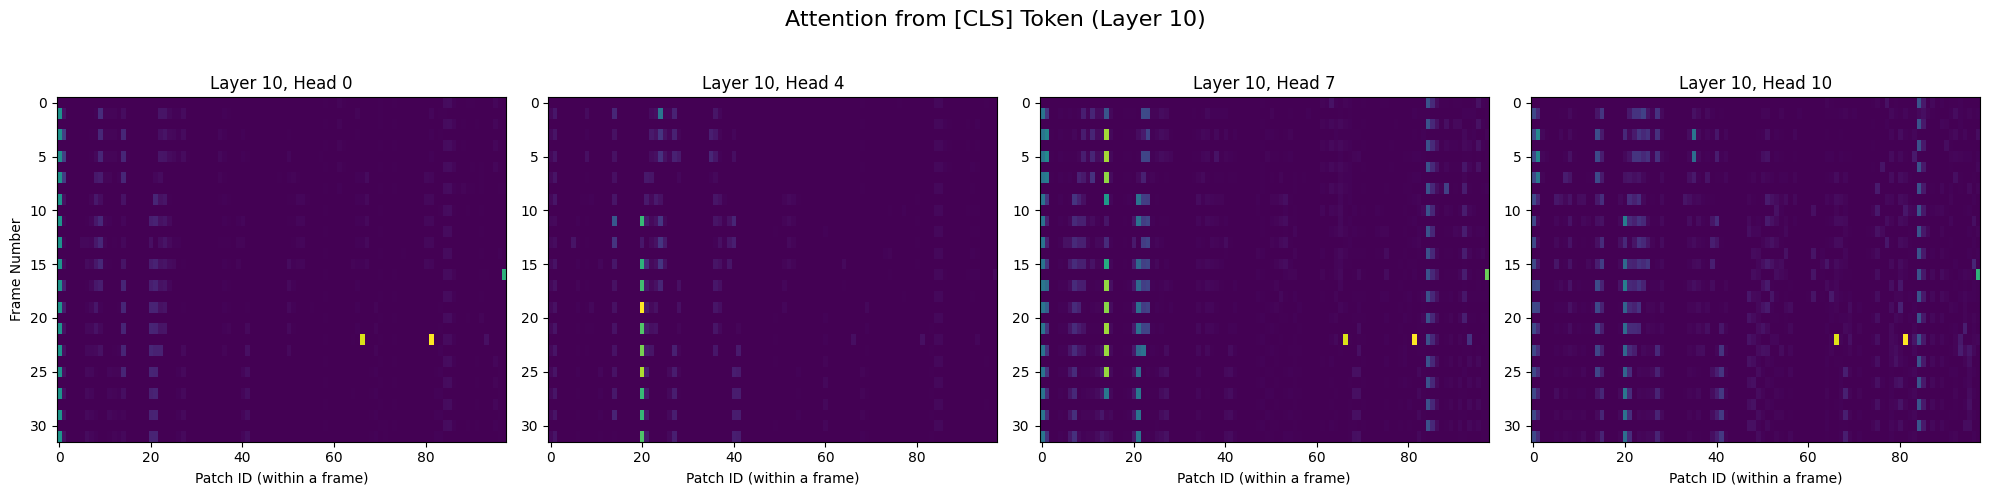

In [ ]:
plot_attention_heatmaps(layer_id=10, head_ids=[0, 4, 7, 10])

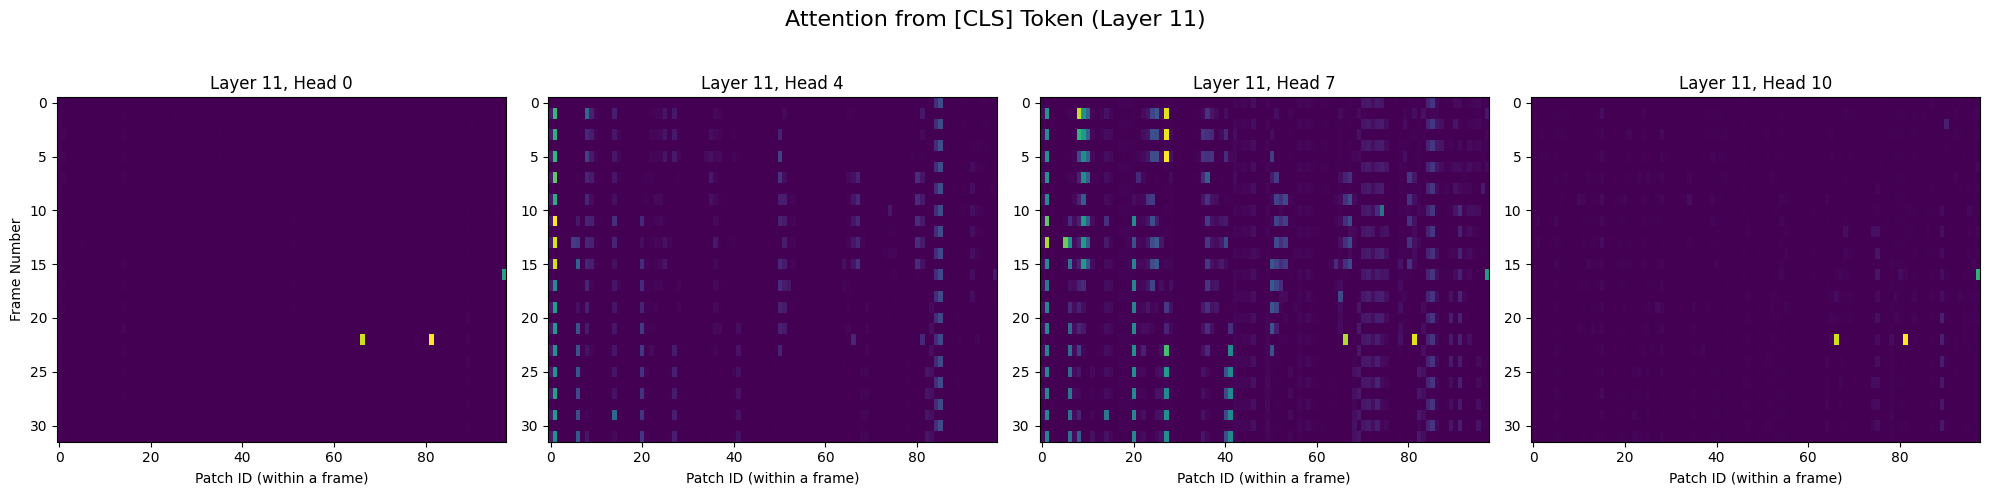

In [ ]:
plot_attention_heatmaps(layer_id=11, head_ids=[0, 4, 7, 10])



In [ ]:
# --- Clean up hooks ---
hook_handle.remove()

### DLA:

In [ ]:
classifier_weights = model.classifier.weight  # shape: (num_classes, hidden_size)
target_weight = classifier_weights[target_class]  # shape: (hidden_size)

# Retrieve the token representations from the hook.
# Expected shape: (1, num_tokens, hidden_size)
tokens = activations['final_tokens'].squeeze(0)  # shape: (num_tokens, hidden_size)

cls_token = tokens[0]  # using only the CLS token

cls_token_norm = model.vivit.layernorm(cls_token)

# Get the classifier's weight and bias.
classifier_weights = model.classifier.weight  # shape: (num_classes, hidden_size)
classifier_bias = model.classifier.bias         # shape: (num_classes,)

target_class = torch.argmax(logits, dim=-1).item()
target_weight = classifier_weights[target_class]  # shape: (hidden_size,)
target_bias = classifier_bias[target_class]         # scalar


cls_contribution = torch.dot(cls_token_norm, target_weight) + target_bias


print("Direct logit attribution (CLS token with normalization):", cls_contribution.item())
print("Model logit for target class:", logits[0, target_class].item())

Direct logit attribution (CLS token with normalization): 15.803919792175293
Model logit for target class: 15.803919792175293


In [ ]:
import matplotlib.pyplot as plt

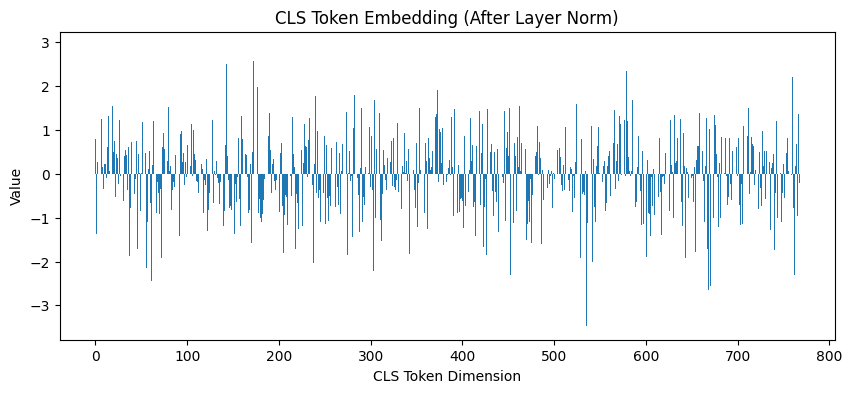

In [ ]:
# For visualization, assume each token corresponds to a frame.
num_tokens = tokens.shape[0]
cls_np = cls_token_norm.detach().cpu().numpy()

plt.figure(figsize=(10, 4))
plt.bar(range(len(cls_np)), cls_np)
plt.xlabel("CLS Token Dimension")
plt.ylabel("Value")
plt.title("CLS Token Embedding (After Layer Norm)")
plt.show()

# Remove the hook when done.
hook_handle.remove()

In [ ]:
# --- Direct Logit Attribution at Token Level ---
# We already have the final tokens via the hook
tokens = activations['final_tokens'].squeeze(0)  # shape: (num_tokens, hidden_size)
print("Total tokens (including CLS):", tokens.shape[0])

# Assume the model uses a CLS token at index 0. We'll exclude it for token-level analysis.
cls_token = tokens[0]  # used for overall logit
tokens_without_cls = tokens[1:]  # these are the per-patch tokens

# Get classifier weights for the predicted class
classifier_weights = model.classifier.weight  # shape: (num_classes, hidden_size)
classifier_bias = model.classifier.bias         # shape: (num_classes,)
target_weight = classifier_weights[target_class]  # shape: (hidden_size,)
target_bias = classifier_bias[target_class]         # scalar

# Compute dot product for each token
token_contributions = torch.matmul(tokens_without_cls, target_weight)  # shape: (num_tokens-1,)

print("Max token contribution:", token_contributions.max().item())
print("Min token contribution:", token_contributions.min().item())

Total tokens (including CLS): 3137
Max token contribution: 141.9432830810547
Min token contribution: -5.832084655761719


Tokens per frame: 98


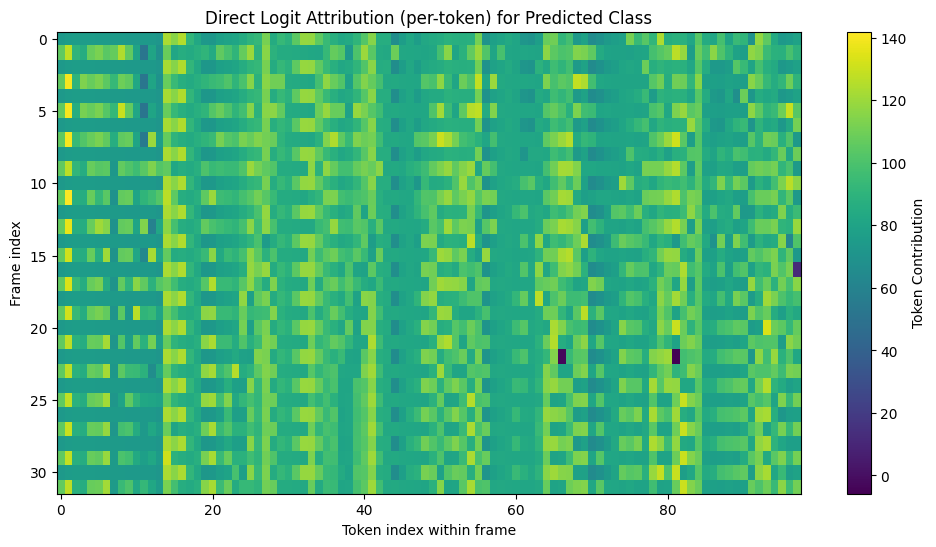

In [ ]:
# --- Reshape token contributions to map to frames ---

# Determine tokens per frame:
total_tokens_without_cls = tokens_without_cls.shape[0]
num_frames = 32  # since we sampled 32 frames
tokens_per_frame = total_tokens_without_cls // num_frames
print("Tokens per frame:", tokens_per_frame)

# Reshape contributions: shape (num_frames, tokens_per_frame)
token_contributions_reshaped = token_contributions.detach().cpu().numpy().reshape(num_frames, tokens_per_frame)


# Plot per-frame logit contributions
# Plot heatmap of token contributions per frame
plt.figure(figsize=(12, 6))
plt.imshow(token_contributions_reshaped, cmap="viridis", aspect="auto")
plt.colorbar(label="Token Contribution")
plt.xlabel("Token index within frame")
plt.ylabel("Frame index")
plt.title("Direct Logit Attribution (per-token) for Predicted Class")
plt.show()

In [ ]:
def compute_layerwise_logits(model, inputs):
    """
    Computes the layerwise target class logit for a single video input.
    Returns a list of logits for each layer (from 0 to 12) and the target class index.
    """

    layer_logits = []
    for layer_idx, hs in enumerate(hidden_states):
        # hs shape: (1, total_tokens, hidden_size); we extract the CLS token (index 0)
        cls_token = hs[0, 0]  # shape: (hidden_size,)
        # Apply the same layer norm that the model uses before classification
        cls_token_norm = model.vivit.layernorm(cls_token)
        # Compute the logit for target class: dot product plus bias
        logit = torch.dot(cls_token_norm, target_weight) + target_bias
        layer_logits.append(logit.item())
    return layer_logits, target_class

# Number of video samples to simulate variability (ideally these would be different videos)
num_samples = 10
all_layer_logits = []  # Will be a list of lists; each inner list has logits from layers 0 to 12

for i in range(num_samples):
    layer_logits, target_class = compute_layerwise_logits(model, inputs)
    all_layer_logits.append(layer_logits)

all_layer_logits = np.array(all_layer_logits)  # Shape: (num_samples, num_layers+1)
num_layers = all_layer_logits.shape[1]  # This should be 13 (layers 0 through 12)


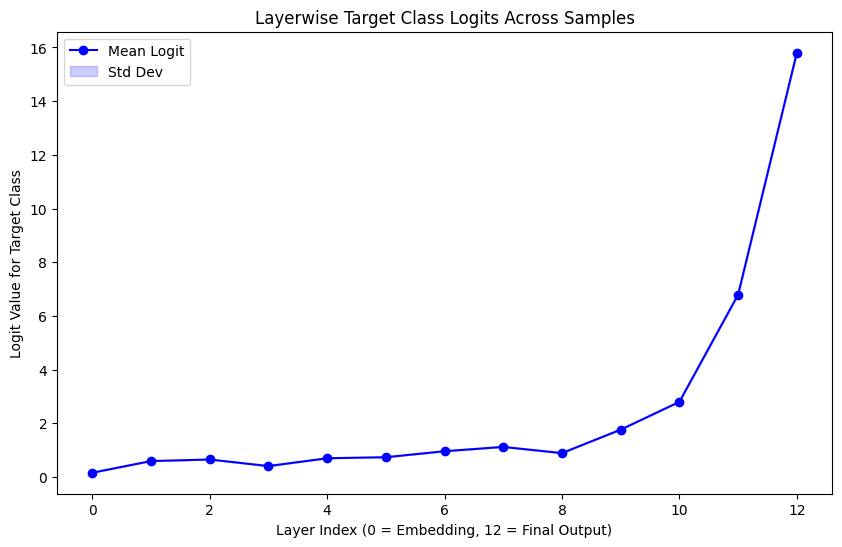

In [ ]:
# Compute the mean and standard deviation for each layer across samples.
mean_logits = np.mean(all_layer_logits, axis=0)
std_logits = np.std(all_layer_logits, axis=0)
layers = np.arange(mean_logits.shape[0])  # layer indices 0 to 12

plt.figure(figsize=(10, 6))
plt.plot(layers, mean_logits, marker='o', linestyle='-', color='blue', label="Mean Logit")
plt.fill_between(layers, mean_logits - std_logits, mean_logits + std_logits,
                 color='blue', alpha=0.2, label="Std Dev")
plt.xlabel("Layer Index (0 = Embedding, 12 = Final Output)")
plt.ylabel("Logit Value for Target Class")
plt.title("Layerwise Target Class Logits Across Samples")
plt.legend()
plt.show()

In [ ]:
# --- Direct Logit Attribution at Token Level (corrected for tubelets) ---

tokens = activations['final_tokens'].squeeze(0)  # (3137, hidden_dim)
print("Total tokens (incl CLS):", tokens.shape[0])

# Drop CLS
tokens_no_cls = tokens[1:]  # (3136, hidden_dim)

# Model params
num_frames = 32
tubelet = 2
h = w = 14  # 224/16 = 14
time = num_frames // tubelet  # 16 tubelets

# Reshape tokens into (time, h, w, hidden_dim)
tokens_reshaped = tokens_no_cls.view(time, h, w, -1)

# Classifier weights
target_class = outputs.logits.argmax(-1).item()
class_w = model.classifier.weight[target_class].to(device)

# Compute contribution per tubelet token
contribs = torch.einsum("thwd,d->thw", tokens_reshaped, class_w)

# Expand tubelets back to 32 frames (duplicate each 2-frame tubelet)
frame_contribs = contribs.repeat_interleave(tubelet, axis=0)  # (32, 14, 14)

print("Frame contribs shape:", frame_contribs.shape)  # (32, 14, 14)


Total tokens (incl CLS): 3137
Frame contribs shape: torch.Size([32, 14, 14])


### CLS Token Visualisation:

In [ ]:
# --- Load Model and Preprocessor ---
model_name = "google/vivit-b-16x2-kinetics400"

image_processor = VivitImageProcessor.from_pretrained(model_name)

model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)

print(f"'{model_name}' loaded successfully.")

'google/vivit-b-16x2-kinetics400' loaded successfully.


In [ ]:
# Enable hidden states output (returns a tuple of 13 hidden states for a 12-layer model)
model.config.output_hidden_states = True
model.eval()

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# This dictionary will store the attention weights from each layer
attention_cache = {}

def get_attention_hook(name):
    """Creates a hook to save attention probabilities."""
    def hook(model, input, output):
        # The attention module's output is a tuple: (hidden_states, attention_probs)
        # We want the second element, the probabilities.
        attention_cache[name] = output[1].detach()
    return hook

# --- Register hooks on ALL attention layers ---
# In ViViT, this is inside model.vivit.encoder.layer[i].attention.attention
for i, layer in enumerate(model.vivit.encoder.layer):
    layer.attention.attention.register_forward_hook(get_attention_hook(f"layer_{i}"))

# --- Run inference to trigger the hooks ---
with torch.no_grad():
    outputs = model(inputs["pixel_values"], output_attentions=True)

# Now, attention_cache is populated with keys 'layer_0', 'layer_1', ..., 'layer_11'
print(f"Captured attention from {len(attention_cache)} layers.")

Captured attention from 12 layers.


Derived 98 patches per frame.


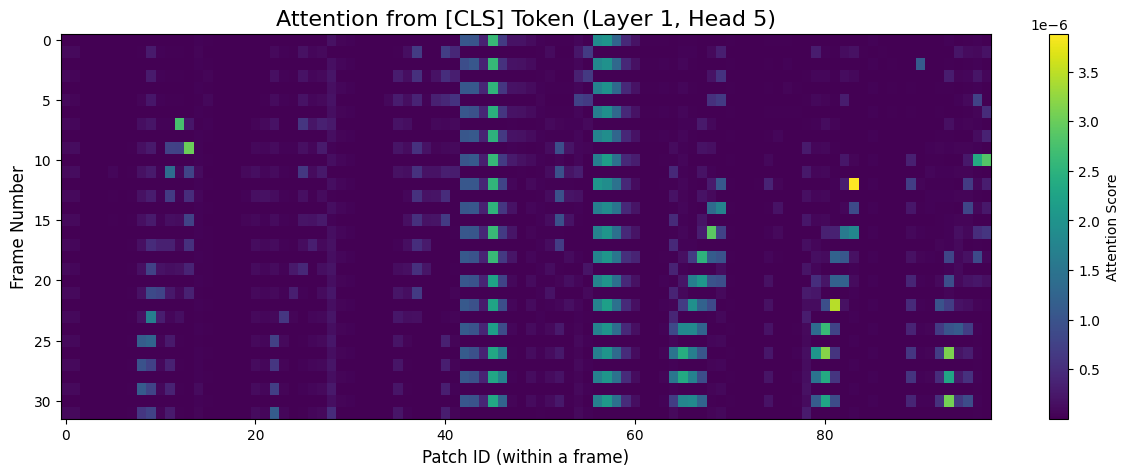

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 1  # Let's inspect the final layer
HEAD_ID = 5   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
num_frames = model.config.num_frames  # 32
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

Derived 98 patches per frame.


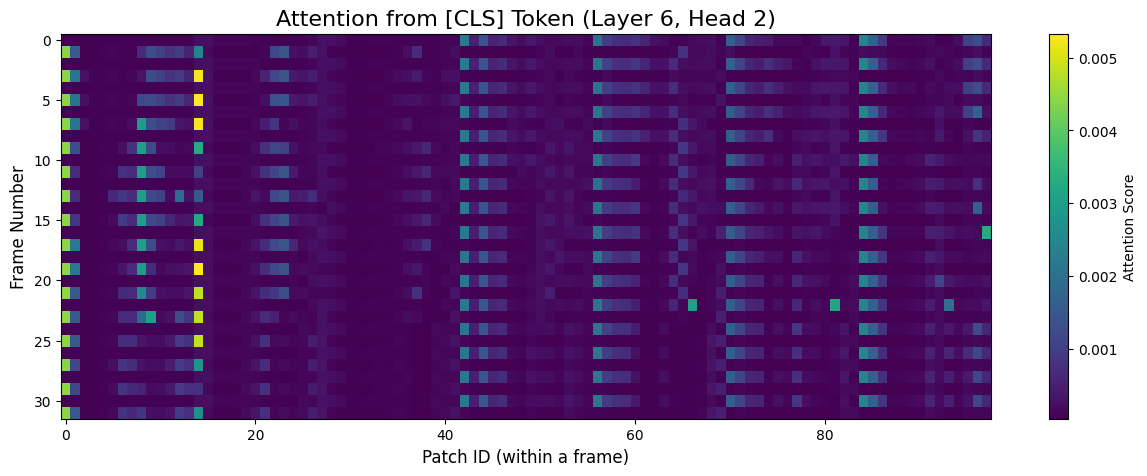

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 6  # Let's inspect the final layer
HEAD_ID = 2   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
num_frames = model.config.num_frames  # 32
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

# This is the most robust way to calculate it.
print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

Derived 98 patches per frame.


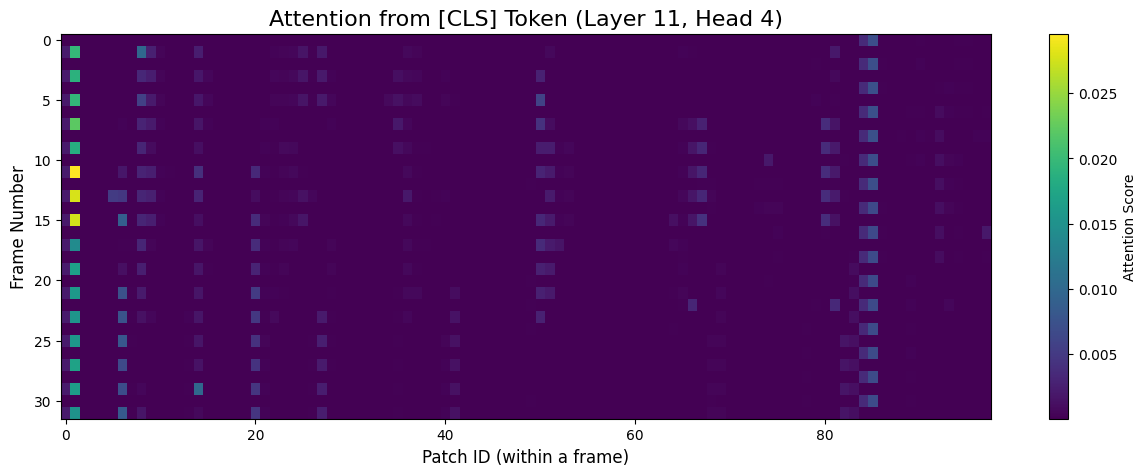

In [ ]:
# --- Visualize attention from the [CLS] token ---

# --- Configuration ---
LAYER_ID = 11  # Let's inspect the final layer
HEAD_ID = 4   # Choose a head to start with
# ---------------------

# The [CLS] token is the first token (index 0)
attention_for_head = attention_cache[f"layer_{LAYER_ID}"][0, HEAD_ID, :, :]
cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

# --- Reshape for visualization ---
num_frames = model.config.num_frames  # 32
num_patches = cls_attention.shape[0]
num_patches_per_frame = num_patches // num_frames

print(f"Derived {num_patches_per_frame} patches per frame.")

# Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

ax.set_title(f'Attention from [CLS] Token (Layer {LAYER_ID}, Head {HEAD_ID})', fontsize=16)
ax.set_xlabel('Patch ID (within a frame)', fontsize=12)
ax.set_ylabel('Frame Number', fontsize=12)
fig.colorbar(im, ax=ax, label='Attention Score')

plt.show()

In [ ]:
def plot_attention_heatmaps(layer_id, head_ids, num_frames=32):
    """
    Plots attention heatmaps for a given layer and a list of heads.

    Args:
        layer_id (int): The layer index to visualize (0-11).
        head_ids (list): A list of head indices to visualize (0-11).
        num_frames (int): The number of frames in the video.
    """

    num_heads_to_plot = len(head_ids)

    # We create a subplot for each head to compare them easily.
    fig, axes = plt.subplots(1, num_heads_to_plot, figsize=(5 * num_heads_to_plot, 5))

    # Ensure axes is an array even for a single head
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i, head_id in enumerate(head_ids):
        # The [CLS] token is the first token (index 0).
        attention_for_head = attention_cache[f"layer_{layer_id}"][0, head_id, :, :]
        cls_attention = attention_for_head[0, 1:]  # Shape: [num_tokens - 1]

        # Calculate patches per frame from the tensor shape
        num_patches = cls_attention.shape[0]
        num_patches_per_frame = num_patches // num_frames

        # Reshape the attention scores into a (num_frames, num_patches_per_frame) grid
        heatmap = cls_attention.reshape(num_frames, num_patches_per_frame).cpu().numpy()

        im = axes[i].imshow(heatmap, cmap='viridis', aspect='auto')
        axes[i].set_title(f'Layer {layer_id}, Head {head_id}', fontsize=12)
        axes[i].set_xlabel('Patch ID (within a frame)', fontsize=10)
        if i == 0:
            # Only set y-label for the first plot for a cleaner look
            axes[i].set_ylabel('Frame Number', fontsize=10)

    fig.suptitle(f'Attention from [CLS] Token (Layer {layer_id})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

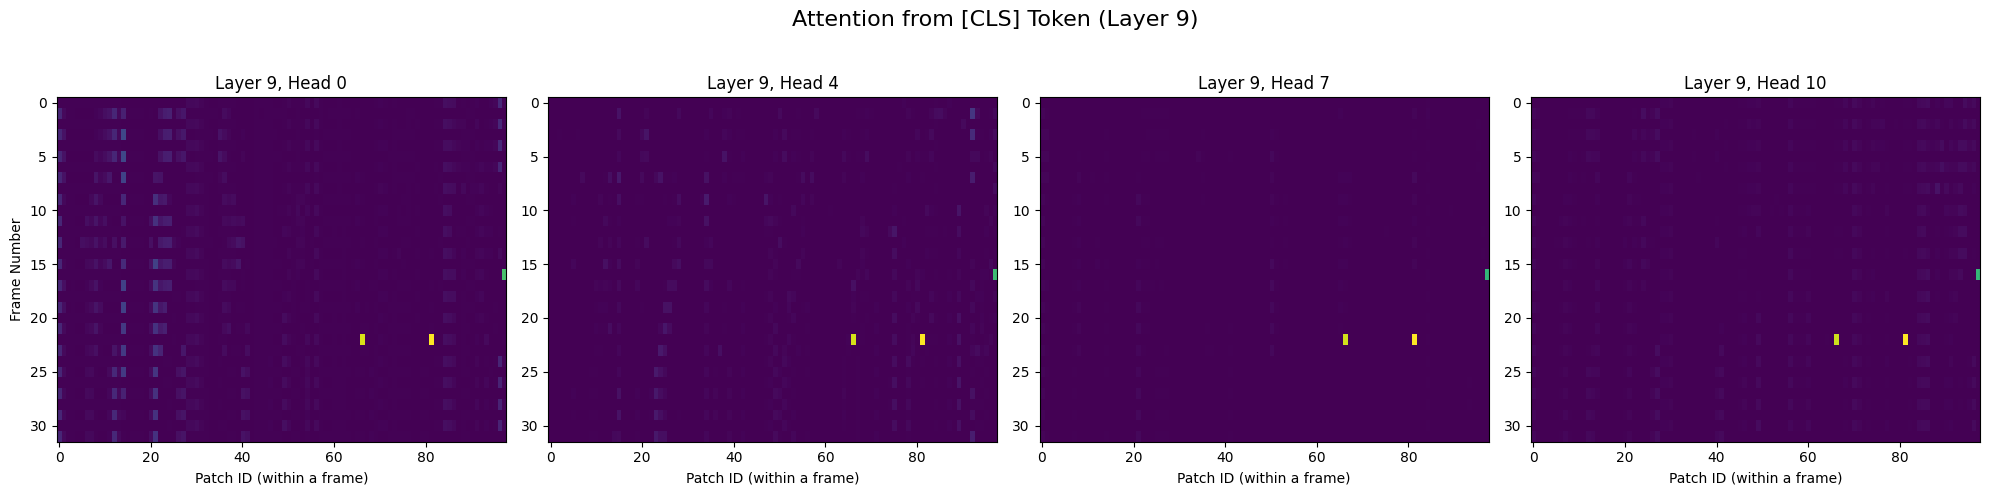

In [ ]:
plot_attention_heatmaps(layer_id=9, head_ids=[0, 4, 7, 10])

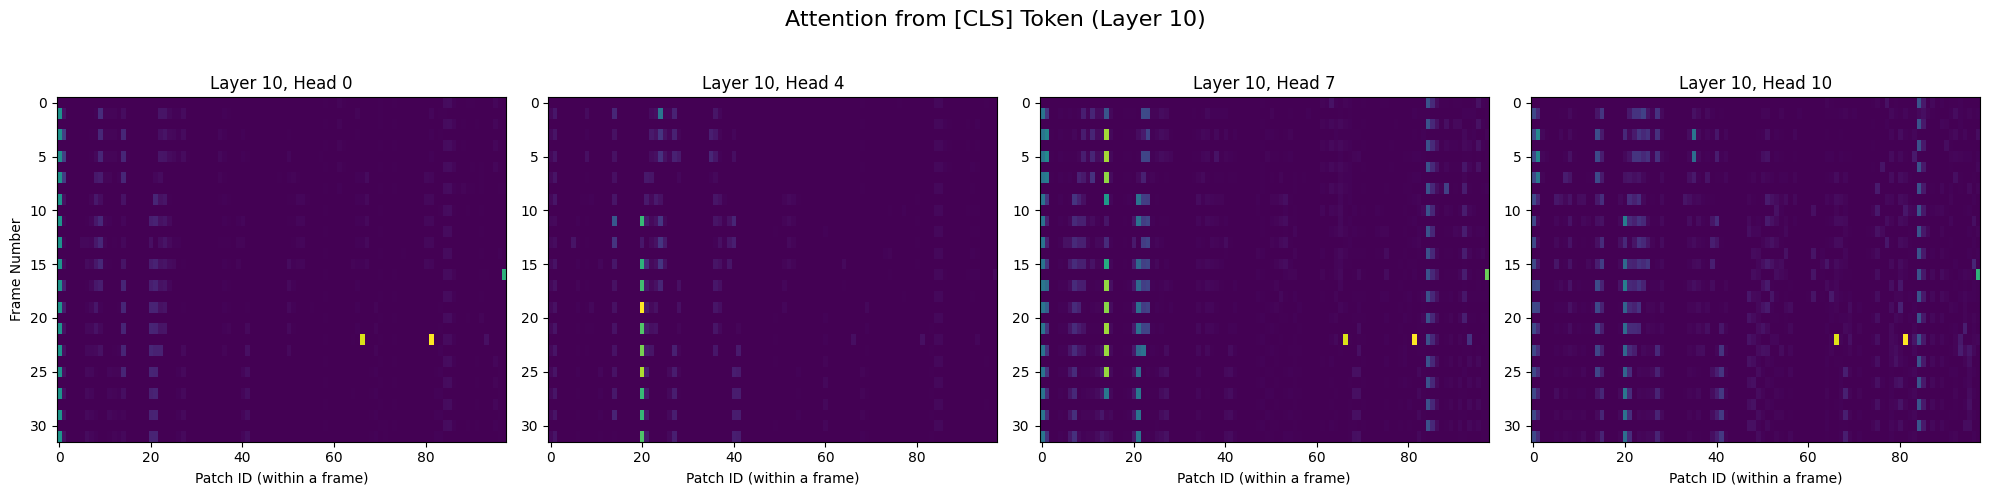

In [ ]:
plot_attention_heatmaps(layer_id=10, head_ids=[0, 4, 7, 10])

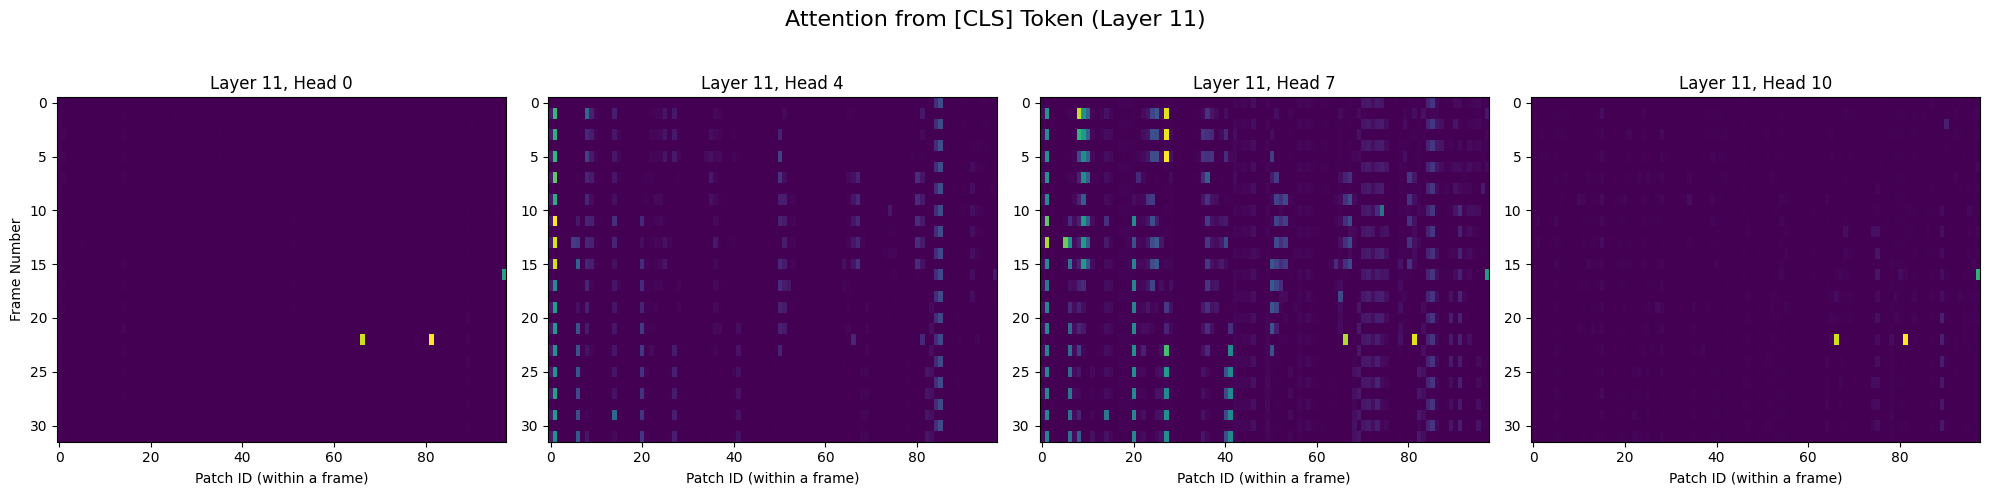

In [ ]:
plot_attention_heatmaps(layer_id=11, head_ids=[0, 4, 7, 10])

In [ ]:
# --- Clean up hooks ---
hook_handle.remove()

### Ablation:

In [ ]:
import torch

# --- 1. Define the Critical Frames to Ablate ---
# Based on your finding that frames 11-12 are the hotspot
FRAME_START = 10
FRAME_END = 13 # Ablating frames 10, 11, 12, 13

# --- 2. Create the Ablated Input Tensor ---
# Start with a copy of the original, correctly processed pixel_values
ablated_pixel_values = inputs['pixel_values'].clone()

# Zero out the pixel values for the critical frames
# The shape is (1, 32, 3, 224, 224) -> (Batch, Frames, Channels, H, W)
ablated_pixel_values[:, FRAME_START:FRAME_END+1, :, :, :] = 0

print(f"Ablated (zeroed out) frames {FRAME_START} through {FRAME_END}.")

# --- 3. Measure the Impact of Ablation ---

# Get the original logits and predicted class
with torch.no_grad():
    original_outputs = model(inputs["pixel_values"], output_attentions=True)
    original_logits = original_outputs.logits
    # The predicted class index for the original video
    predicted_class_idx = original_logits.argmax(-1).item()
    original_logit_score = original_logits[0, predicted_class_idx]
    original_class_name = model.config.id2label[predicted_class_idx]

# Get the logits using the ablated input
with torch.no_grad():
    ablated_outputs = model(ablated_pixel_values, output_attentions=True)
    ablated_logits = ablated_outputs.logits
    # Get the logit score FOR THE ORIGINAL CLASS
    ablated_logit_score_for_original_class = ablated_logits[0, predicted_class_idx]

    # Also, let's see what the model predicts now
    new_predicted_class_idx = ablated_logits.argmax(-1).item()
    new_class_name = model.config.id2label[new_predicted_class_idx]


# --- 4. Report the Results ---
print(f"\nOriginal Predicted Class: '{original_class_name}' (Logit: {original_logit_score:.4f})")
print(f"Ablated Logit for '{original_class_name}': {ablated_logit_score_for_original_class:.4f}")

logit_change = original_logit_score - ablated_logit_score_for_original_class
print(f"Logit Drop: {logit_change:.4f}")

print(f"\nNew Predicted Class after Ablation: '{new_class_name}'")

Ablated (zeroed out) frames 10 through 13.

Original Predicted Class: 'LABEL_31' (Logit: 15.8039)
Ablated Logit for 'LABEL_31': 16.3009
Logit Drop: -0.4970

New Predicted Class after Ablation: 'LABEL_31'


In [ ]:
import torch
import torch.nn.functional as F
import gc

# --- Step 1: Start with a Clean Slate ---
# Reload the model to ensure all old hooks are gone. This is the most reliable way.
print("Reloading a fresh model to guarantee no lingering hooks...")
model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400").to(device)
print("Model reloaded successfully.")


# --- Step 2: Run the Lean Logit Analysis ---
# Notice we are NOT registering any hooks and NOT using output_attentions=True.

# --- Process ORIGINAL video ---
with torch.no_grad():
    original_outputs = model(inputs["pixel_values"])
    original_logits = original_outputs.logits[0]

original_top5 = torch.topk(F.softmax(original_logits, dim=-1), 5)
original_top5_indices_cpu = original_top5.indices.cpu()
original_logits_cpu = original_logits.cpu()

# Clean up memory
del original_outputs, original_logits
torch.cuda.empty_cache()
gc.collect()

# --- Process ABLATED video ---
with torch.no_grad():
    ablated_outputs = model(ablated_pixel_values)
    ablated_logits = ablated_outputs.logits[0]

ablated_top5 = torch.topk(F.softmax(ablated_logits, dim=-1), 5)
ablated_top5_indices_cpu = ablated_top5.indices.cpu()
ablated_logits_cpu = ablated_logits.cpu()

# Clean up memory
del ablated_outputs, ablated_logits
torch.cuda.empty_cache()
gc.collect()


# --- Step 3: Compare the results ---
print("\n--- ORIGINAL PREDICTIONS ---")
for i in range(5):
    class_idx = original_top5_indices_cpu[i].item()
    class_name = model.config.id2label[class_idx]
    logit_val = original_logits_cpu[class_idx].item()
    print(f"{i+1}. {class_name:<25} (Logit: {logit_val:.4f})")

print("\n--- ABLATED PREDICTIONS ---")
for i in range(5):
    class_idx = ablated_top5_indices_cpu[i].item()
    class_name = model.config.id2label[class_idx]
    logit_val = ablated_logits_cpu[class_idx].item()
    print(f"{i+1}. {class_name:<25} (Logit: {logit_val:.4f})")

print("\n--- ANALYSIS OF KEY LOGIT CHANGES ---")
for i in range(5):
    class_idx = original_top5_indices_cpu[i].item()
    class_name = model.config.id2label[class_idx]

    original_logit = original_logits_cpu[class_idx].item()
    ablated_logit = ablated_logits_cpu[class_idx].item()
    change = ablated_logit - original_logit

    print(f"Change for '{class_name}': {change:.4f}")

Reloading a fresh model to guarantee no lingering hooks...
Model reloaded successfully.

--- ORIGINAL PREDICTIONS ---
1. LABEL_31                  (Logit: 15.8039)
2. LABEL_357                 (Logit: 5.5540)
3. LABEL_150                 (Logit: 4.9153)
4. LABEL_224                 (Logit: 4.3363)
5. LABEL_227                 (Logit: 4.1988)

--- ABLATED PREDICTIONS ---
1. LABEL_31                  (Logit: 16.3009)
2. LABEL_357                 (Logit: 6.2596)
3. LABEL_150                 (Logit: 5.2864)
4. LABEL_227                 (Logit: 4.3939)
5. LABEL_245                 (Logit: 4.2623)

--- ANALYSIS OF KEY LOGIT CHANGES ---
Change for 'LABEL_31': 0.4970
Change for 'LABEL_357': 0.7056
Change for 'LABEL_150': 0.3712
Change for 'LABEL_224': -0.3632
Change for 'LABEL_227': 0.1952


## Training Probes:

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- Load Model and Preprocessor ---
model_name = "google/vivit-b-16x2-kinetics400"
# The image processor handles resizing, normalization, and formatting.[2]
image_processor = VivitImageProcessor.from_pretrained(model_name)
# We load the standard Hugging Face model. We will add our own hooks to it.
model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)

print(f"'{model_name}' loaded successfully.")

'google/vivit-b-16x2-kinetics400' loaded successfully.


In [ ]:
# Enable hidden states output (returns a tuple of 13 hidden states for a 12-layer model)
model.config.output_hidden_states = True
model.eval()

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bi

In [ ]:
# --- PROBE EXPERIMENT SETUP ---

# This dictionary will store the activations from every layer for a single forward pass
activation_cache = {}

def get_activation_hook(name):
    """Creates a hook to save the output of a module."""
    def hook(model, input, output):
        # The output of a transformer layer block is usually a tuple; we want the first element
        activation_cache[name] = output[0].detach()
    return hook

In [ ]:
# --- Function to run a video and collect all its layer activations ---
def get_all_layer_activations(video_filename):
    """
    Processes a video and returns a dictionary of activations from each layer's residual stream.
    """
    # Clear the cache for a new run
    activation_cache.clear()

    # Register hooks on the output of ALL 12 transformer layers
    hooks = []
    for i, layer in enumerate(model.vivit.encoder.layer):
        hook = layer.output.register_forward_hook(get_activation_hook(f"layer_{i}"))
        hooks.append(hook)

    # --- Pre-process the Video ---
    file_path = hf_hub_download(
        repo_id="chereddysaivreddy/kinetics-400", filename=video_filename, repo_type="dataset"
    )
    container = av.open(file_path)
    indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container=container, indices=indices)
    inputs = image_processor(list(video), return_tensors="pt").to(device)

    # --- Run Inference ---
    with torch.no_grad():
        outputs = model(**inputs)

    # --- Clean up hooks ---
    for hook in hooks:
        hook.remove()

    # Return a copy of the captured activations
    return activation_cache.copy()

In [ ]:
# --- Now, collect activations for both videos ---
print("Collecting activations for the 'strike' video...")
hit_activations = get_all_layer_activations("bowling/bowling_plain.mp4")

print("\nCollecting activations for the 'gutter' video...")
gutter_activations = get_all_layer_activations("bowling/bowling_gutter.mp4")

print(f"\nSuccessfully collected activations from {len(hit_activations)} layers for both videos.")
# Example: Access the CLS token activation for layer 5 of the 'hit' video
# hit_activations['layer_5'][0, 0, :]



Successfully collected activations from 12 layers for both videos.


In [ ]:
# --- TRAIN AND EVALUATE PROBES ---

probe_accuracies = []
num_layers = len(model.vivit.encoder.layer)

print("Training one probe for each layer...")
for i in range(num_layers):
    # 1. Prepare the data for this layer
    # We will probe the CLS token's representation (index 0)
    hit_cls_token = hit_activations[f'layer_{i}'].squeeze()[0, :]
    gutter_cls_token = gutter_activations[f'layer_{i}'].squeeze()[0, :]

    # Create feature matrix X and label vector y
    X_train = torch.stack([hit_cls_token, gutter_cls_token]).cpu().numpy()
    y_train = np.array([1, 0]) # 1 for "hit", 0 for "gutter"

    # 2. Train a simple linear probe
    probe = LogisticRegression()
    probe.fit(X_train, y_train)

    # 3. Evaluate the probe's accuracy on its training data
    # High accuracy means the concept is linearly separable
    accuracy = probe.score(X_train, y_train)
    probe_accuracies.append(accuracy)

    print(f"Layer {i} Probe Accuracy: {accuracy*100:.1f}%")

Training one probe for each layer...
Layer 0 Probe Accuracy: 100.0%
Layer 1 Probe Accuracy: 100.0%
Layer 2 Probe Accuracy: 100.0%
Layer 3 Probe Accuracy: 100.0%
Layer 4 Probe Accuracy: 100.0%
Layer 5 Probe Accuracy: 100.0%
Layer 6 Probe Accuracy: 100.0%
Layer 7 Probe Accuracy: 100.0%
Layer 8 Probe Accuracy: 100.0%
Layer 9 Probe Accuracy: 100.0%
Layer 10 Probe Accuracy: 100.0%
Layer 11 Probe Accuracy: 100.0%


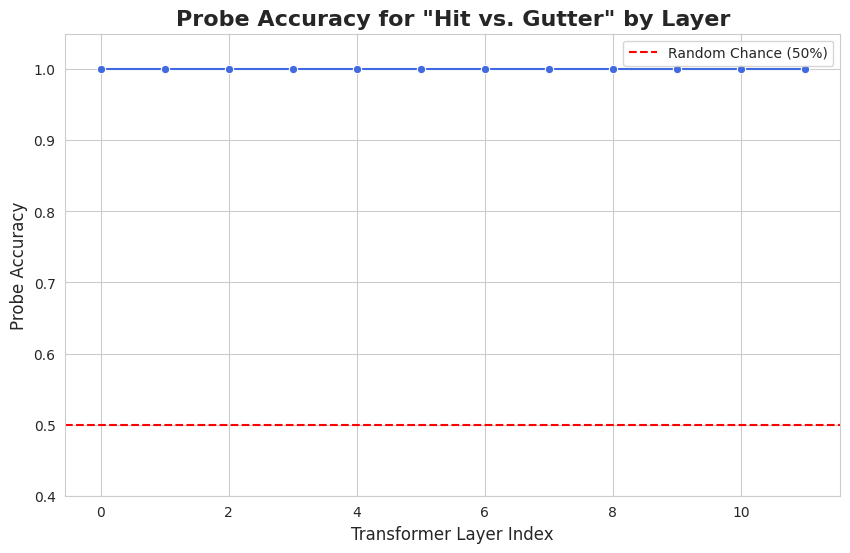

In [ ]:
# --- VISUALIZE PROBE ACCURACY ---

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Layer': list(range(num_layers)),
    'Accuracy': probe_accuracies
})

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plot = sns.lineplot(x='Layer', y='Accuracy', data=results_df, marker='o', color='royalblue')

plot.set_title('Probe Accuracy for "Hit vs. Gutter" by Layer', fontsize=16, weight='bold')
plot.set_xlabel('Transformer Layer Index', fontsize=12)
plot.set_ylabel('Probe Accuracy', fontsize=12)
plot.set_ylim(0.4, 1.05) # Start y-axis at 0.4 to emphasize the jump from 0.5 (random chance)
plot.axhline(0.5, ls='--', color='red', label='Random Chance (50%)')
plt.legend()
plt.show()

Training one probe for each layer using all patch tokens...
Layer 0 Probe Test Accuracy: 99.9%
Layer 1 Probe Test Accuracy: 100.0%
Layer 2 Probe Test Accuracy: 100.0%
Layer 3 Probe Test Accuracy: 100.0%
Layer 4 Probe Test Accuracy: 100.0%
Layer 5 Probe Test Accuracy: 99.9%
Layer 6 Probe Test Accuracy: 100.0%
Layer 7 Probe Test Accuracy: 100.0%
Layer 8 Probe Test Accuracy: 100.0%
Layer 9 Probe Test Accuracy: 100.0%
Layer 10 Probe Test Accuracy: 100.0%
Layer 11 Probe Test Accuracy: 100.0%


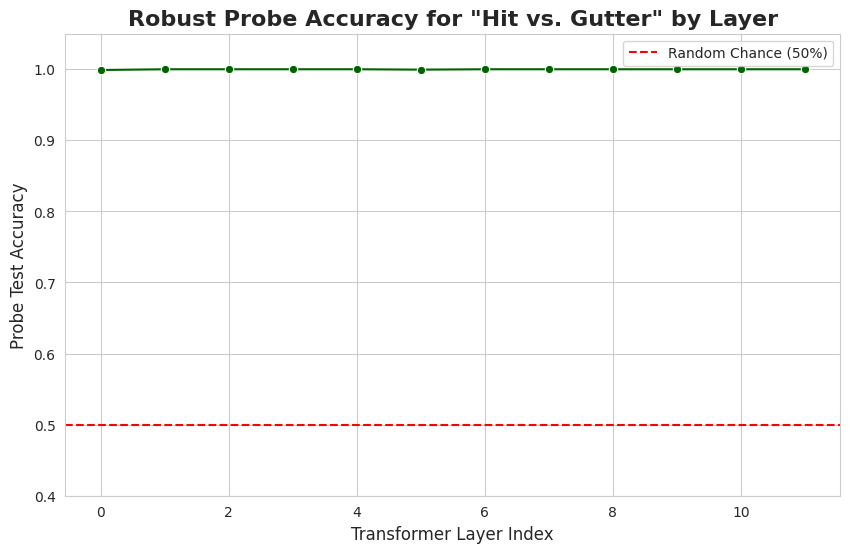

In [ ]:
# --- REVISED PROBE EXPERIMENT (WITH ALL TOKENS AND TRAIN-TEST SPLIT) ---

from sklearn.model_selection import train_test_split

probe_test_accuracies = []
num_layers = len(model.vivit.encoder.layer)

print("Training one probe for each layer using all patch tokens...")
for i in range(num_layers):
    # 1. Prepare a much larger dataset for this layer
    # We will use ALL patch tokens (all tokens except the CLS token at index 0)
    hit_patch_tokens = hit_activations[f'layer_{i}'].squeeze()[1:, :]
    gutter_patch_tokens = gutter_activations[f'layer_{i}'].squeeze()[1:, :]

    # Create feature matrix X by concatenating all tokens
    X = torch.cat([hit_patch_tokens, gutter_patch_tokens], dim=0).cpu().numpy()

    # Create label vector y (1 for all "hit" tokens, 0 for all "gutter" tokens)
    y = np.concatenate([
        np.ones(hit_patch_tokens.shape[0]),
        np.zeros(gutter_patch_tokens.shape[0])
    ])

    # 2. Perform a train-test split to prevent overfitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 3. Train a simple linear probe on the training data
    probe = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
    probe.fit(X_train, y_train)

    # 4. Evaluate the probe's accuracy on the HELD-OUT test data
    # This is the true measure of how well it learned the general concept
    test_accuracy = probe.score(X_test, y_test)
    probe_test_accuracies.append(test_accuracy)

    print(f"Layer {i} Probe Test Accuracy: {test_accuracy*100:.1f}%")

# --- VISUALIZE THE NEW, MORE ROBUST RESULTS ---

# Create a DataFrame for easy plotting
results_df_robust = pd.DataFrame({
    'Layer': list(range(num_layers)),
    'Test Accuracy': probe_test_accuracies
})

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plot = sns.lineplot(x='Layer', y='Test Accuracy', data=results_df_robust, marker='o', color='darkgreen')

plot.set_title('Robust Probe Accuracy for "Hit vs. Gutter" by Layer', fontsize=16, weight='bold')
plot.set_xlabel('Transformer Layer Index', fontsize=12)
plot.set_ylabel('Probe Test Accuracy', fontsize=12)
plot.set_ylim(0.4, 1.05)
plot.axhline(0.5, ls='--', color='red', label='Random Chance (50%)')
plt.legend()
plt.show()

## Delta Analysis:

Calculating the magnitude of the activation difference (delta) at each layer...
Layer 0 - Average Delta Magnitude: 75.2657
Layer 1 - Average Delta Magnitude: 68.4624
Layer 2 - Average Delta Magnitude: 69.5781
Layer 3 - Average Delta Magnitude: 68.9352
Layer 4 - Average Delta Magnitude: 75.0200
Layer 5 - Average Delta Magnitude: 100.4468
Layer 6 - Average Delta Magnitude: 121.1980
Layer 7 - Average Delta Magnitude: 133.3447
Layer 8 - Average Delta Magnitude: 145.7053
Layer 9 - Average Delta Magnitude: 171.5556
Layer 10 - Average Delta Magnitude: 202.6537
Layer 11 - Average Delta Magnitude: 270.0284


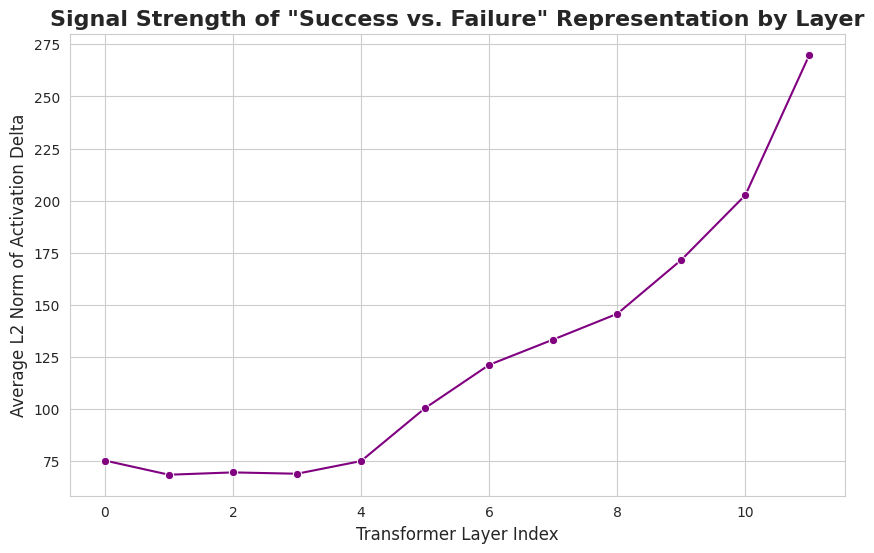

In [ ]:
# --- FINAL PROBE EXPERIMENT: DELTA ANALYSIS ---

import pandas as pd
import seaborn as sns
import numpy as np
import torch

# - hit_activations: A dictionary with layer activations for the "strike" video.
# - gutter_activations: A dictionary for the "gutter" video.

layer_delta_magnitudes = []
num_layers = len(model.vivit.encoder.layer)

print("Calculating the magnitude of the activation difference (delta) at each layer...")
for i in range(num_layers):
    # 1. Get the activations for this layer for both videos
    hit_acts = hit_activations[f'layer_{i}'].squeeze()
    gutter_acts = gutter_activations[f'layer_{i}'].squeeze()

    # 2. Calculate the difference (delta)
    # This shows what the model's representation adds for the "hit" outcome
    delta = hit_acts - gutter_acts

    # 3. Calculate the L2 norm (magnitude) for each token's delta vector
    # This measures the size of the change for each token
    norms = torch.linalg.norm(delta, dim=1).cpu().numpy()

    # 4. Store the average magnitude for this layer
    # This gives us a single value representing the overall signal strength at this layer
    average_norm = np.mean(norms)
    layer_delta_magnitudes.append(average_norm)

    print(f"Layer {i} - Average Delta Magnitude: {average_norm:.4f}")


# --- VISUALIZE THE DELTA MAGNITUDE RESULTS ---

# Create a DataFrame for easy plotting
delta_df = pd.DataFrame({
    'Layer': list(range(num_layers)),
    'Average Delta Magnitude': layer_delta_magnitudes
})

# Plot using seaborn for a nice aesthetic
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plot = sns.lineplot(x='Layer', y='Average Delta Magnitude', data=delta_df, marker='o', color='purple')

plot.set_title('Signal Strength of "Success vs. Failure" Representation by Layer', fontsize=16, weight='bold')
plot.set_xlabel('Transformer Layer Index', fontsize=12)
plot.set_ylabel('Average L2 Norm of Activation Delta', fontsize=12)
plt.show()

## Component Ablations:

In [ ]:
import torch
import numpy as np
import av
from transformers import VivitForVideoClassification, VivitImageProcessor
from huggingface_hub import hf_hub_download

# --- 1. Setup (Fixed Seed) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/vivit-b-16x2-kinetics400"
model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)
model.eval()
image_processor = VivitImageProcessor.from_pretrained(model_name)

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    np.random.seed(42) # Fixed Seed
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def load_video(filename):
    file_path = hf_hub_download(repo_id="chereddysaivreddy/kinetics-400", filename=filename, repo_type="dataset")
    container = av.open(file_path)
    indices = sample_frame_indices(32, 4, container.streams.video[0].frames)
    frames = []
    container.seek(0)
    for i, frame in enumerate(container.decode(video=0)):
        if i >= indices[0] and i in indices:
            frames.append(frame.to_ndarray(format="rgb24"))
        if len(frames) == len(indices): break
    inputs = image_processor(list(np.stack(frames)), return_tensors="pt")
    if inputs["pixel_values"].ndim == 4: inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)
    return inputs.to(device)

# --- 2. Load Data ---
print("Loading videos with Seed 42...")
inputs_strike = load_video("bowling/bowling_plain.mp4")
inputs_gutter = load_video("bowling/bowling_gutter.mp4")

# --- 3. Automated Ablation Function ---
def run_ablation_top5(inputs, label="Video"):
    print(f"\n{'='*20} {label} Video Analysis (Seed 42) {'='*20}")

    # A. Get Clean Activations & Logits
    activations = {}
    def hook(m, i, o): activations['act'] = o.detach()
    h = model.vivit.encoder.layer[11].output.register_forward_hook(hook)

    with torch.no_grad():
        clean_out = model(**inputs)
        clean_logits = clean_out.logits[0]
    h.remove()

    # B. Calculate DLA for "Bowling" (Index 31)
    tokens = activations['act'].squeeze(0)[1:] # Remove CLS
    target_weight = model.classifier.weight[31] # Bowling
    dla_scores = torch.matmul(tokens, target_weight)

    # C. Identify Top 10% Hotspots
    k = int(dla_scores.shape[0] * 0.10)
    _, top_indices = torch.topk(dla_scores, k)

    # D. Create Ablated Input
    ablated_pixel_values = inputs['pixel_values'].clone()
    patch_size = 16
    patches_per_row = 14

    for idx in top_indices:
        idx = idx.item()
        frame_idx = idx // 196
        remainder = idx % 196
        h_start = (remainder // patches_per_row) * patch_size
        w_start = (remainder % patches_per_row) * patch_size

        # Zero out patch
        ablated_pixel_values[0, frame_idx, :, h_start:h_start+patch_size, w_start:w_start+patch_size] = 0

    # E. Run Ablated Inference
    with torch.no_grad():
        ablated_out = model(pixel_values=ablated_pixel_values)
        ablated_logits = ablated_out.logits[0]

    # F. Print Top 5 Table
    top5 = torch.topk(clean_logits, 5)
    indices = top5.indices.cpu().numpy()

    print(f"{'Rank':<5} | {'Class Name':<25} | {'Original':<10} | {'Ablated':<10} | {'Change':<10}")
    print("-" * 75)

    for rank, idx in enumerate(indices):
        name = model.config.id2label[idx]
        orig_val = clean_logits[idx].item()
        abl_val = ablated_logits[idx].item()
        change = abl_val - orig_val
        print(f"{rank+1:<5} | {name:<25} | {orig_val:<10.4f} | {abl_val:<10.4f} | {change:<10.4f}")

# --- 4. EXECUTE ---
run_ablation_top5(inputs_strike, "Strike")
run_ablation_top5(inputs_gutter, "Gutter")

Loading videos with Seed 42...

==================== Strike Video Analysis (Seed 42) ====================
Rank  | Class Name                | Original   | Ablated    | Change    
---------------------------------------------------------------------------
1     | LABEL_31                  | 16.9954    | 16.6583    | -0.3371   
2     | LABEL_357                 | 9.0371     | 9.1341     | 0.0970    
3     | LABEL_227                 | 6.2185     | 6.4343     | 0.2158    
4     | LABEL_152                 | 5.9146     | 5.7234     | -0.1912   
5     | LABEL_84                  | 5.7508     | 5.7579     | 0.0072    

==================== Gutter Video Analysis (Seed 42) ====================
Rank  | Class Name                | Original   | Ablated    | Change    
---------------------------------------------------------------------------
1     | LABEL_31                  | 16.5200    | 16.5044    | -0.0156   
2     | LABEL_357                 | 6.3758     | 6.6308     | 0.2551    
3     | LA

## Activations Patching:

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import av
from transformers import VivitForVideoClassification, VivitImageProcessor
from huggingface_hub import hf_hub_download

# --- 1. SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/vivit-b-16x2-kinetics400"
model = VivitForVideoClassification.from_pretrained(model_name, attn_implementation="eager").to(device)
model.eval()
image_processor = VivitImageProcessor.from_pretrained(model_name)

# --- 2. FIXED SAMPLING (Solves the "Drifting Baseline" Bug) ---
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    np.random.seed(42) # Ensures every run sees the exact same frames
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def load_video(filename):
    file_path = hf_hub_download(repo_id="chereddysaivreddy/kinetics-400", filename=filename, repo_type="dataset")
    container = av.open(file_path)
    indices = sample_frame_indices(32, 4, container.streams.video[0].frames)
    frames = []
    container.seek(0)
    for i, frame in enumerate(container.decode(video=0)):
        if i >= indices[0] and i in indices:
            frames.append(frame.to_ndarray(format="rgb24"))
        if len(frames) == len(indices): break
    inputs = image_processor(list(np.stack(frames)), return_tensors="pt")
    if inputs["pixel_values"].ndim == 4: inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)
    return inputs.to(device)

# Load Inputs (Deterministic now!)
inputs_strike = load_video("bowling/bowling_plain.mp4")
inputs_gutter = load_video("bowling/bowling_gutter.mp4")

Max Signal (Denominator): 265.3773
L4 ATTN: 54.41%
L4 MLP: 60.17%
L5 ATTN: 50.22%
L5 MLP: 57.49%
L6 ATTN: 43.62%
L6 MLP: 49.11%
L7 ATTN: 40.38%
L7 MLP: 42.55%
L8 ATTN: 37.72%
L8 MLP: 42.10%
L9 ATTN: 44.44%
L9 MLP: 58.66%
L10 ATTN: 47.61%
L10 MLP: 43.39%


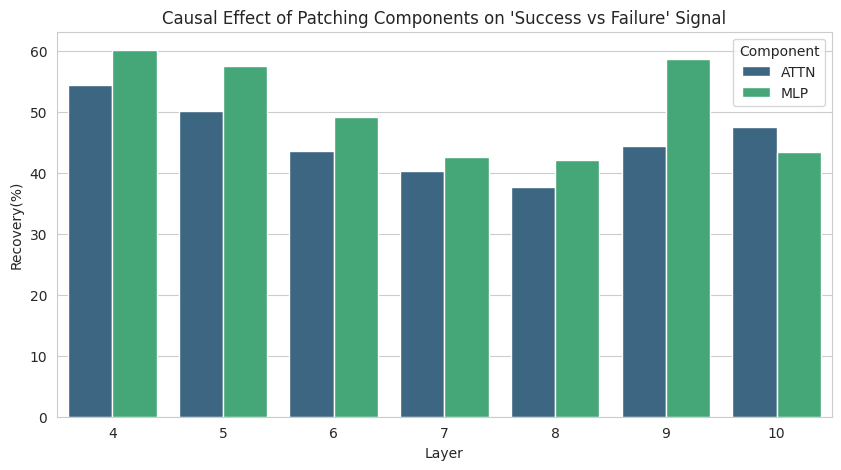

In [ ]:


# --- 3. CACHING CLEAN ACTIVATIONS (The "Update" Vectors) ---
clean_cache = {}
def cache_hook(name):
    def hook(model, input, output):
        # Attention returns tuple (hidden, weights); MLP Dense returns tensor
        act = output[0] if isinstance(output, tuple) else output
        clean_cache[name] = act.detach()
    return hook

hooks = []
for i in range(12):
    # Patch Attention (Returns the Attention Update)
    hooks.append(model.vivit.encoder.layer[i].attention.register_forward_hook(cache_hook(f"L{i}_attn")))

    # Patch MLP Dense (Returns the MLP Update BEFORE Residual)
    # Note: We target 'output.dense' which is the projection before dropout/residual
    hooks.append(model.vivit.encoder.layer[i].output.dense.register_forward_hook(cache_hook(f"L{i}_mlp")))

with torch.no_grad():
    model(**inputs_strike)
for h in hooks: h.remove()

# --- 4. RUNNING PATCHING ---
patch_storage = {}
def patch_hook(module, input, output):
    if 'val' in patch_storage:
        if isinstance(output, tuple): return (patch_storage['val'],) + output[1:]
        return patch_storage['val']
    return output

# Helper to get Layer 11 state
def get_final_state(inputs):
    storage = {}
    def h(m, i, o): storage['v'] = o[0].detach() if isinstance(o, tuple) else o.detach()
    # We measure at Layer 11 Output (The accumulated stream)
    handle = model.vivit.encoder.layer[11].output.register_forward_hook(h)
    with torch.no_grad(): model(**inputs)
    handle.remove()
    return storage['v']

# Baseline Delta
state_strike = get_final_state(inputs_strike)
state_gutter = get_final_state(inputs_gutter)
max_delta_norm = torch.linalg.norm(state_strike - state_gutter, dim=-1).mean().item()
print(f"Max Signal (Denominator): {max_delta_norm:.4f}")

results = []
layers_to_patch = range(4, 11)

for layer_idx in layers_to_patch:
    for comp_type in ['attn', 'mlp']:
        # Setup Patch
        patch_storage['val'] = clean_cache[f"L{layer_idx}_{comp_type}"]

        # Select Target
        if comp_type == 'attn': target = model.vivit.encoder.layer[layer_idx].attention
        else: target = model.vivit.encoder.layer[layer_idx].output.dense # Patching ONLY the MLP update

        handle = target.register_forward_hook(patch_hook)

        # Measure
        state_patched = get_final_state(inputs_gutter)
        handle.remove()

        # Calculate Recovery
        delta_patched = state_patched - state_gutter
        recovery = torch.linalg.norm(delta_patched, dim=-1).mean().item()
        pct = (recovery / max_delta_norm) * 100

        results.append({'Layer': layer_idx, 'Component': comp_type.upper(),'Label': f"L{layer_idx} {comp_type.upper()}", 'Recovery(%)': pct})
        print(f"L{layer_idx} {comp_type.upper()}: {pct:.2f}%")

# --- 5. PLOT ---
df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Layer', y='Recovery(%)', hue='Component', palette='viridis')
plt.title("Causal Effect of Patching Components on 'Success vs Failure' Signal")
plt.show()


--- Patching Experiment Results ---
    Layer Component     Label  Recovery(%)
0       4      ATTN   L4 ATTN    54.410638
1       4       MLP    L4 MLP    60.167263
2       5      ATTN   L5 ATTN    50.219765
3       5       MLP    L5 MLP    57.491618
4       6      ATTN   L6 ATTN    43.617004
5       6       MLP    L6 MLP    49.109734
6       7      ATTN   L7 ATTN    40.383055
7       7       MLP    L7 MLP    42.551244
8       8      ATTN   L8 ATTN    37.715879
9       8       MLP    L8 MLP    42.103006
10      9      ATTN   L9 ATTN    44.438936
11      9       MLP    L9 MLP    58.659855
12     10      ATTN  L10 ATTN    47.613590
13     10       MLP   L10 MLP    43.389011


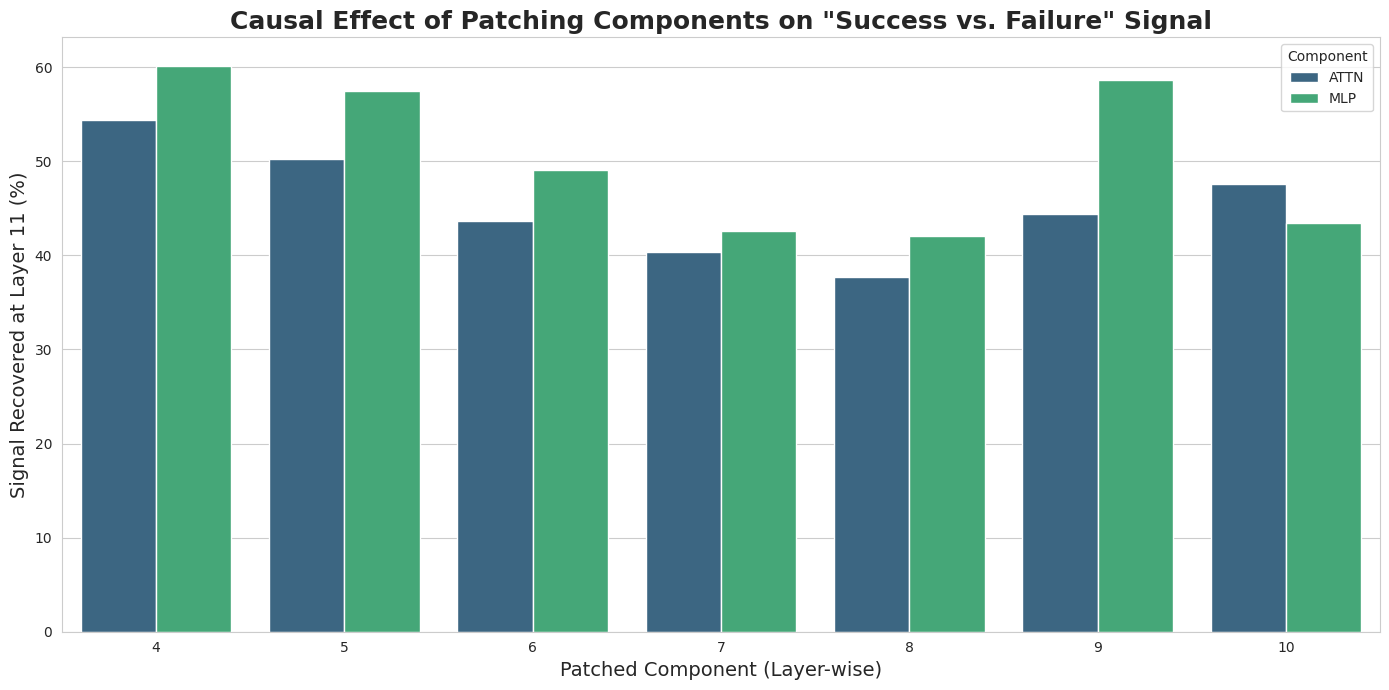

In [ ]:
# --- 5. Visualize the Results ---
results_df = pd.DataFrame(results)
print("\n--- Patching Experiment Results ---")
print(results_df)

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
bar_plot = sns.barplot(
    data=results_df,
    x='Layer',
    y='Recovery(%)',
    hue='Component',
    palette='viridis'
)

bar_plot.set_title('Causal Effect of Patching Components on "Success vs. Failure" Signal', fontsize=18, weight='bold')
bar_plot.set_xlabel('Patched Component (Layer-wise)', fontsize=14)
bar_plot.set_ylabel(f'Signal Recovered at Layer {MEASUREMENT_LAYER} (%)', fontsize=14)
#plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()